### Research Process 


#### Init Libraries

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

#### Load Dataset and split into Features and Label

In [2]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [5]:
#split the data
from sklearn.model_selection import train_test_split
XData_train_val, XData_test, ydata_train_val, ydata_test = train_test_split(X, y, test_size=0.2, random_state=42)
XData_train, XData_val, ydata_train, ydata_val = train_test_split(XData_train_val, ydata_train_val, test_size=0.2, random_state=42)

#### Scale the data

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(XData_train)
X_test = scaler.transform(XData_test)
X_val = scaler.transform(XData_val)

X_train_val = XData_train_val.values

y_train = ydata_train
y_test = ydata_test
y_val = ydata_val

y_train_val = ydata_train_val

#### Handling the imbalance between the classes

In [7]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.7878787878787878, 1: 1.368421052631579}

as predicted the minorty class 'M'=1 gets higher weight of 1.368

### Neural Networks

##### Init Libraries

In [8]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

##### Function Helpers

In [9]:
def model_result(model):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name}')

    # accuracy
    result = model.evaluate(X_test, y_test, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm_test = confusion_matrix(y_test, y_pred)    
    #sns.heatmap(cm_test,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm_test, display_labels=le.classes_)
    cm_disp.plot()
    plt.show()

    # classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [10]:
def model_history(history, param=None):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    if param is None:
        plt.title('Train and Validation Loss')
    else:
        plt.title(f'Train and Validation Loss on {param}')

    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')

    if param is None:
        plt.title('Train and Validation Accuracy')
    else:
        plt.title(f'Train and Validation Accuracy on {param}')
        
    plt.legend()

    plt.show()    

In [11]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]    

    val_recall = history.history['val_recall'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss, 'Validation Recall': val_recall}

In [12]:
def model_fit(model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', metrics.Recall(name='recall')])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [13]:
def model_kfold(xtrain, ytrain, model_base, optimizer=optimizers.RMSprop,learning_rate=0.001, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 5).split(xtrain, ytrain)
    
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss',  'Validation Recall'])
    for k , (train, valid) in enumerate(fold_k):

        scaler = RobustScaler()

        X_train = scaler.fit_transform(xtrain[train])
        X_val = scaler.transform(xtrain[valid])
        
        dataset = {'X_train': X_train, 'y_train': ytrain[train], 'X_val': X_val, 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())

        

        history, model = model_fit(model, optimizer=optimizer, learning_rate=learning_rate, epochNum=epochNum, batchSize=batchSize, en_reduce_lr=en_reduce_lr, en_early_stopping=en_early_stopping, Dataset=dataset, verbose=verbose)    
        
        proc_data = proc_history(history)

        new_row = {'k': k, **proc_data}

        result_df.loc[len(result_df)] = new_row

    return result_df

##### Build the model

In [14]:
models_list = []

### SLP

In [15]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

#### Baseline

In [16]:
CURRENT_MODEL = models.Sequential(name=f'SLP_1')

CURRENT_MODEL.add(layers.Input((30,)))
CURRENT_MODEL.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model = models.clone_model(CURRENT_MODEL)
model.set_weights(CURRENT_MODEL.get_weights())

##### Baseline - Results

In [18]:
history, model = model_fit(model, epochNum=1000, batchSize=32, verbose=0)

proc_data = proc_history(history)

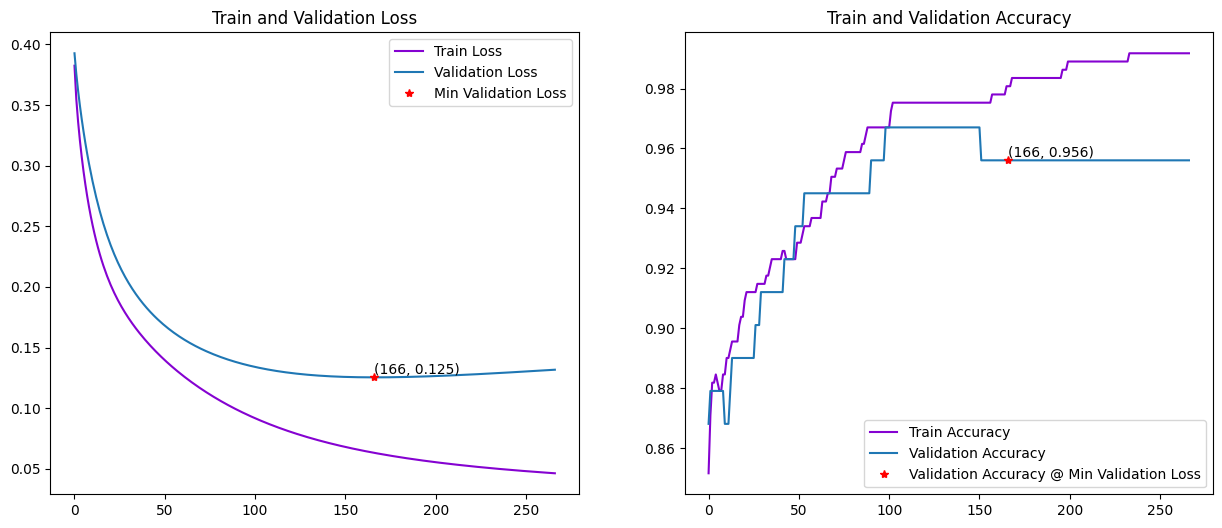

In [19]:
model_history(history)

In [20]:
model.set_weights(CURRENT_MODEL.get_weights())

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, batchSize=32, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Validation Accuracy Mean: 0.08246158920228482, Validation Accuracy STD: 0.037931709699782476
Validation Loss Mean: 0.08246158920228482, Validation Loss STD: 0.037931709699782476


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.986264    0.052286             0.978022         0.072851   
1  1        0.986264    0.055113             0.956044         0.115238   
2  2        0.983516    0.057466             0.989011         0.020662   
3  3        0.978022    0.062736             0.978022         0.098382   
4  4        0.986264    0.049848             0.967033         0.105175   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.941176  
4           0.970588

#### Optimizers

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.adam.Adam'>


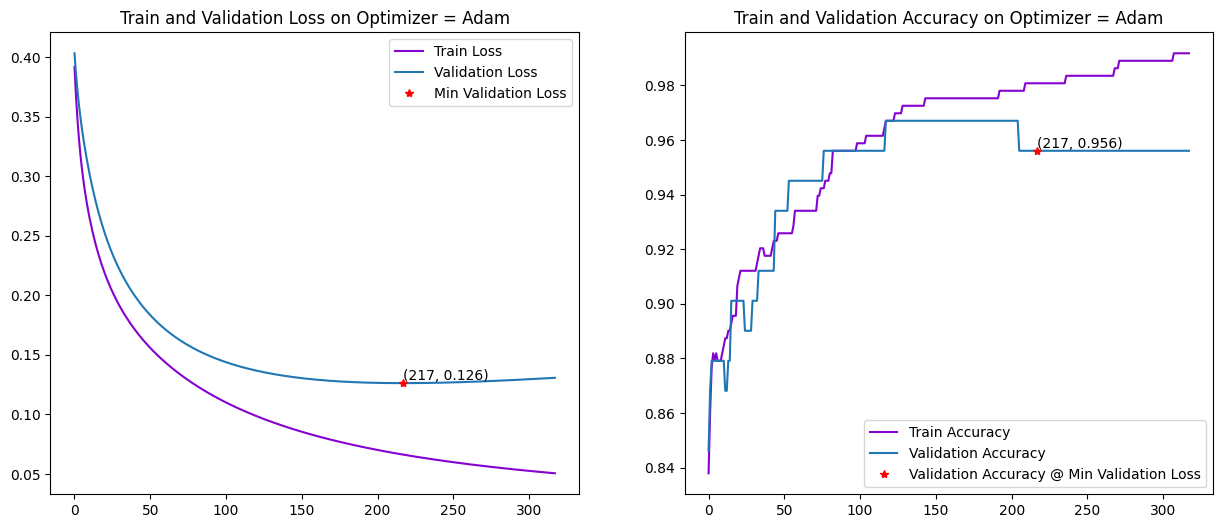

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.rmsprop.RMSprop'>


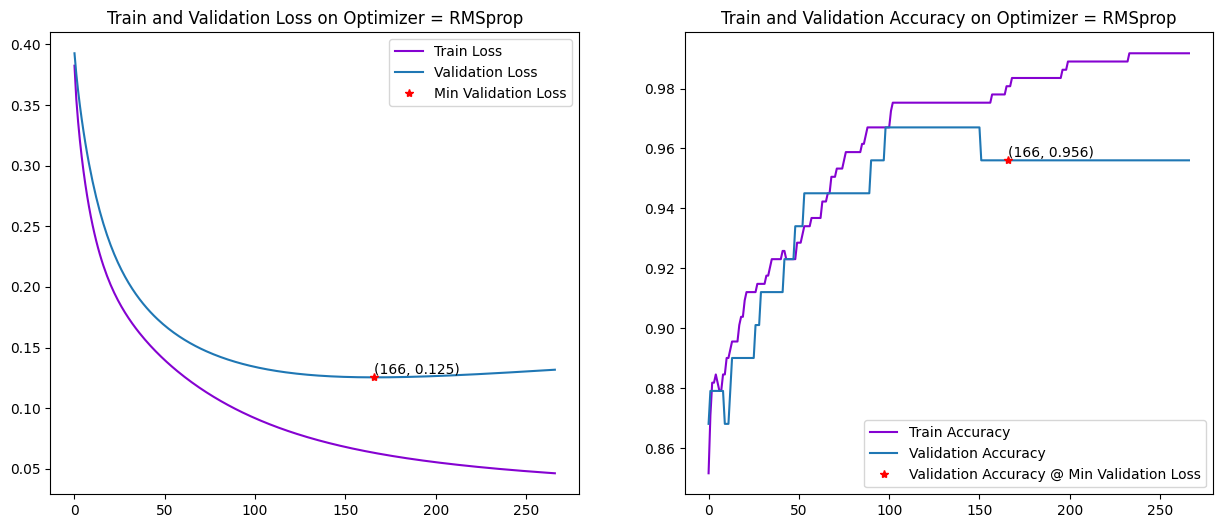

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.sgd.SGD'>


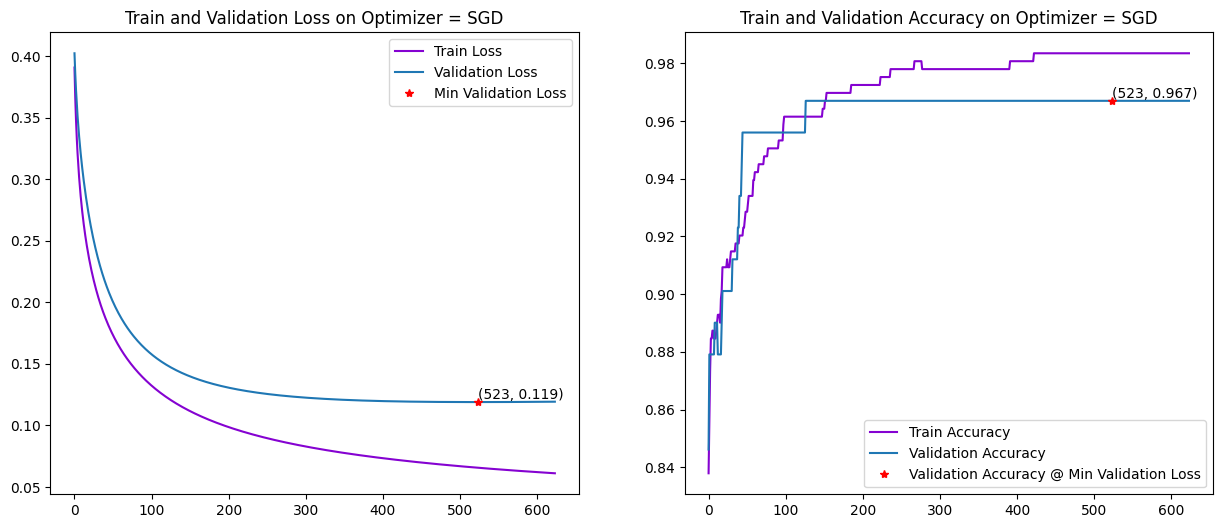

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.adagrad.Adagrad'>


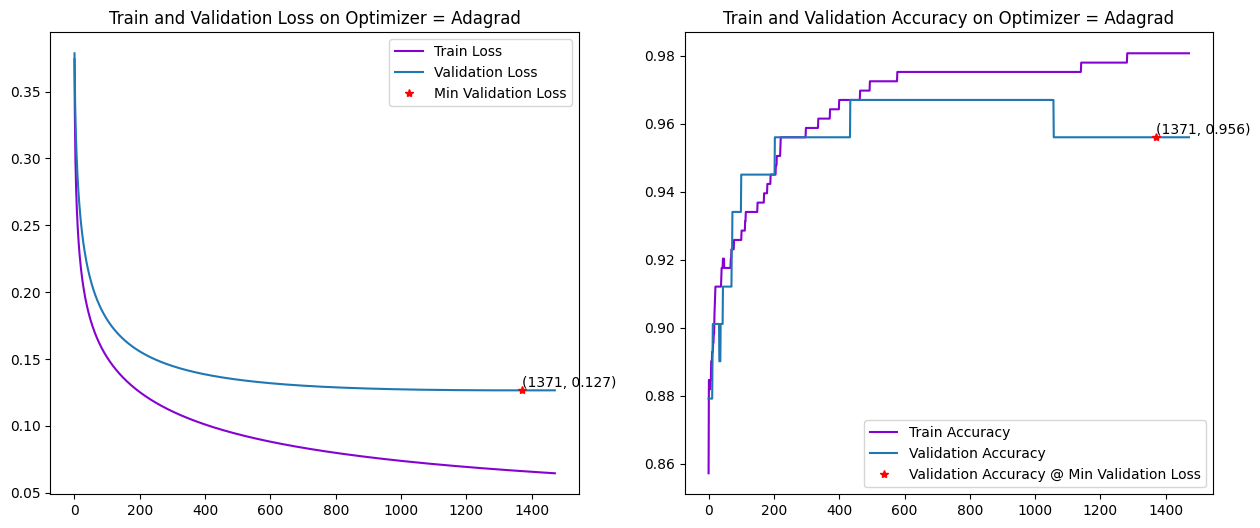

In [21]:
df_optimizer = pd.DataFrame(columns=['Optimizer', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

for optimizer in [optimizers.Adam, optimizers.RMSprop, optimizers.SGD, optimizers.Adagrad]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Optimizer = {optimizer}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    learning_rate = 0.001
    if(optimizer == optimizers.SGD or optimizer==optimizers.Adagrad):
        learning_rate = 0.01

    history, model = model_fit(model, optimizer=optimizer, learning_rate = learning_rate, epochNum=2000, en_early_stopping=True, verbose=0)        
    proc_data = proc_history(history)
    
    new_row = {'Optimizer': optimizer.__name__, **proc_data}
    df_optimizer.loc[len(df_optimizer)] = new_row
    model_history(history, f'Optimizer = {optimizer.__name__}')


In [22]:
df_optimizer

Optimizer  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0      Adam        0.980769    0.066222             0.956044         0.126273   
1   RMSprop        0.980769    0.063214             0.956044         0.125455   
2       SGD        0.983516    0.065625             0.967033         0.118939   
3   Adagrad        0.980769    0.066138             0.956044         0.126544   

   Validation Recall  
0           0.944444  
1           0.944444  
2           0.944444  
3           0.944444

Conclusion: We can see in the graphs that the optimizers achieve similar results, while SGD and Adagrad take a large amount of Epochs to converge.

In [23]:
model.set_weights(CURRENT_MODEL.get_weights())
ADAM_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.Adam, learning_rate=0.001, epochNum=1000, batchSize=32, verbose=0)

model.set_weights(CURRENT_MODEL.get_weights())
RMS_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=1000, batchSize=32, verbose=0)

model.set_weights(CURRENT_MODEL.get_weights())
SGD_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.SGD, learning_rate=0.01, epochNum=1000, batchSize=32, verbose=0)

In [24]:
print(f"Validation Loss Mean: {ADAM_res_df['Validation Loss'].mean()}, Validation Loss STD: {ADAM_res_df['Validation Loss'].std()}")
ADAM_res_df

Validation Loss Mean: 0.08508216179907321, Validation Loss STD: 0.03704659783428757


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.980769    0.055729             0.978022         0.078401   
1  1        0.986264    0.054009             0.956044         0.116546   
2  2        0.983516    0.057743             0.989011         0.023635   
3  3        0.978022    0.063037             0.978022         0.101506   
4  4        0.983516    0.050727             0.967033         0.105323   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.941176  
4           0.970588

In [25]:
print(f"Validation Loss Mean: {RMS_res_df['Validation Loss'].mean()}, Validation Loss STD: {RMS_res_df['Validation Loss'].std()}")
RMS_res_df

Validation Loss Mean: 0.08246158920228482, Validation Loss STD: 0.037931709699782476


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.986264    0.052286             0.978022         0.072851   
1  1        0.986264    0.055113             0.956044         0.115238   
2  2        0.983516    0.057466             0.989011         0.020662   
3  3        0.978022    0.062736             0.978022         0.098382   
4  4        0.986264    0.049848             0.967033         0.105175   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.941176  
4           0.970588

In [26]:
print(f"Validation Loss Mean: {SGD_res_df['Validation Loss'].mean()}, Validation Loss STD: {SGD_res_df['Validation Loss'].std()}")
SGD_res_df

Validation Loss Mean: 0.08725217282772064, Validation Loss STD: 0.028655515721158594


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.975275    0.072066             0.978022         0.071256   
1  1        0.986264    0.061415             0.956044         0.113698   
2  2        0.978022    0.075566             0.989011         0.044762   
3  3        0.978022    0.069382             0.978022         0.100967   
4  4        0.980769    0.060408             0.967033         0.105578   

   Validation Recall  
0           1.000000  
1           0.941176  
2           1.000000  
3           0.941176  
4           0.970588

Conclusion: We will take the best Optimizer as SGD, as it yields the lowest STD value in the Validation Loss.

In [19]:
BEST_OPTIMIZER = optimizers.SGD

#### Learning-Rate

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.1


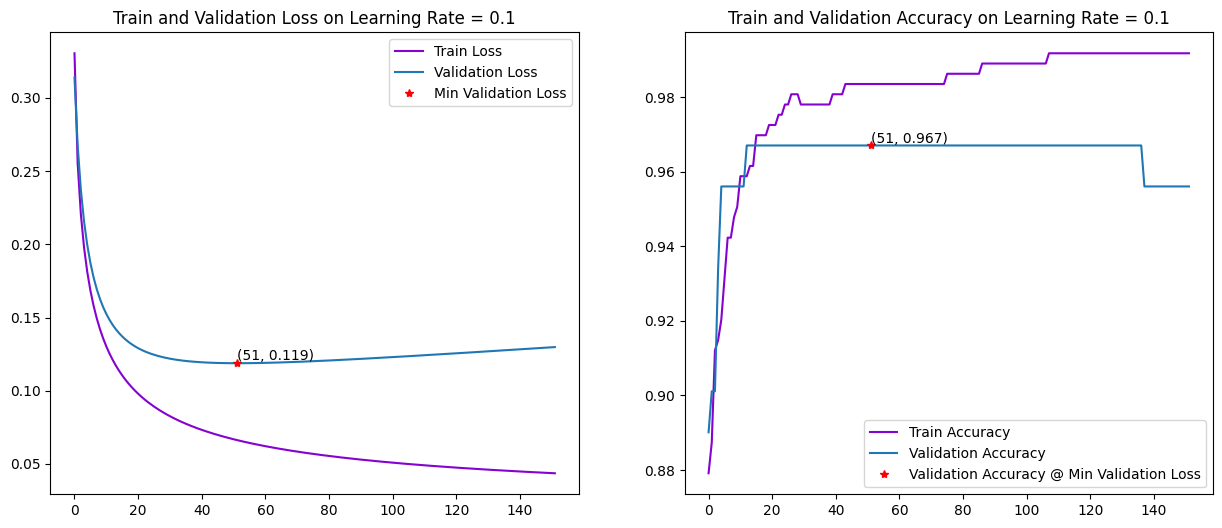

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.01


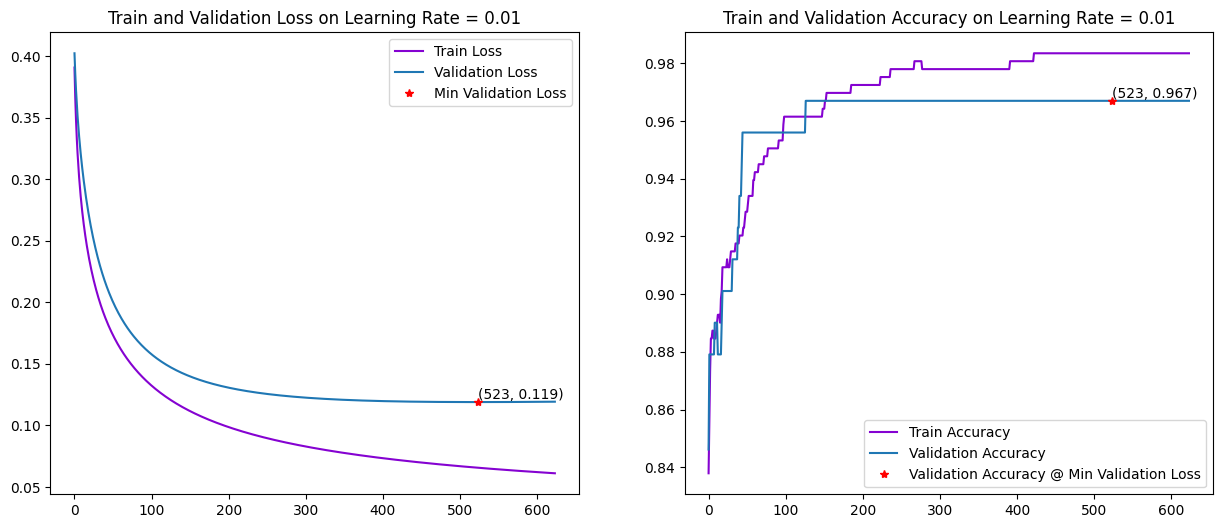

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.001


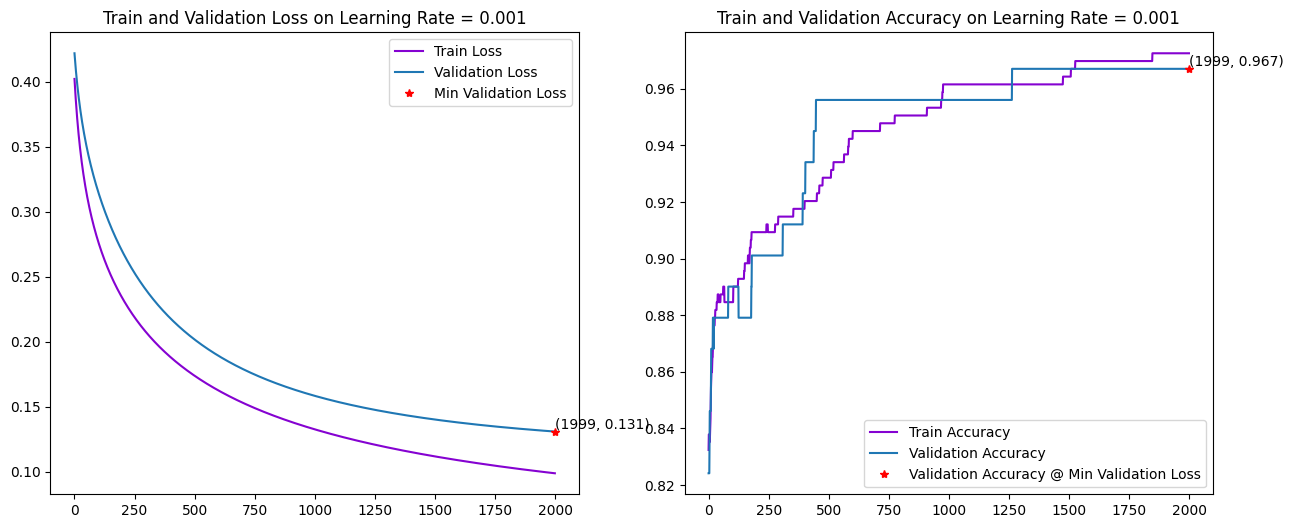

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.0001


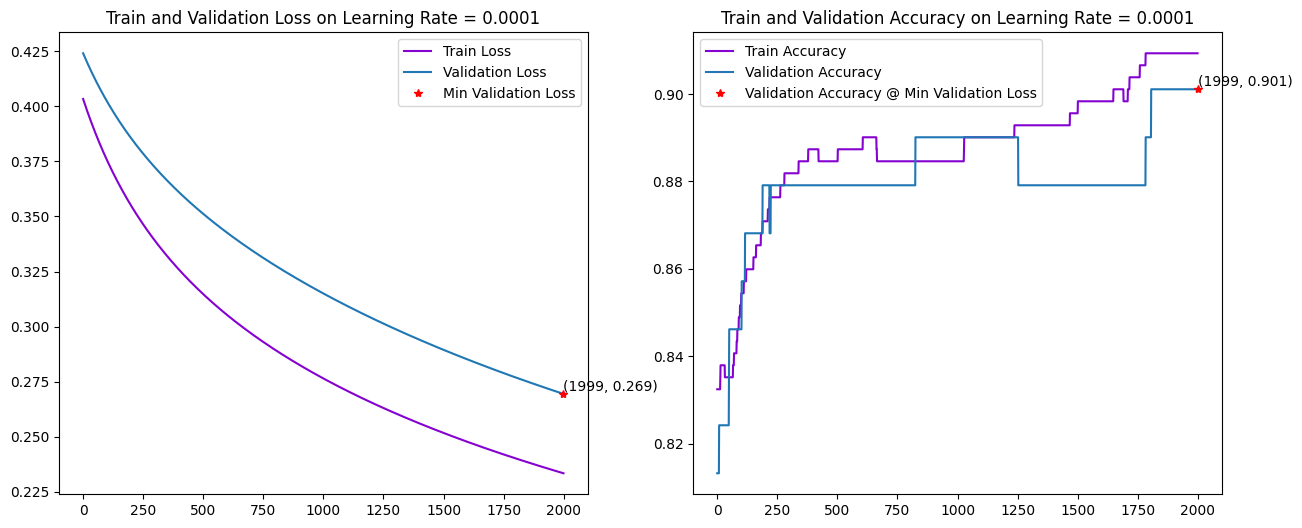

In [28]:
df_res = pd.DataFrame(columns=['Learning Rate', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Learning Rate = {learning_rate}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    history, model = model_fit(model, optimizer=BEST_OPTIMIZER, learning_rate=learning_rate, epochNum=2000, en_early_stopping=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Learning Rate': learning_rate, **proc_data}
    df_res.loc[len(df_res)] = new_row
    model_history(history, f'Learning Rate = {learning_rate}')


Conlusion: From the graphs above, we can infer that a learning rate of 0.1 and 0.01 yields the same results, however with a learning rate of 0.1 it yields the result 10 times faster, which means the model can handle a large learning rate at the begining of the training. <br>
In the next steps, we will include a learning rate scheduler, which will decrease the learning rate once it reaches a plateau.

In [20]:
BEST_LEARNING_RATE = 0.1

#### Network Architecture

In [30]:
nn_arch_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

##### NN 30x1

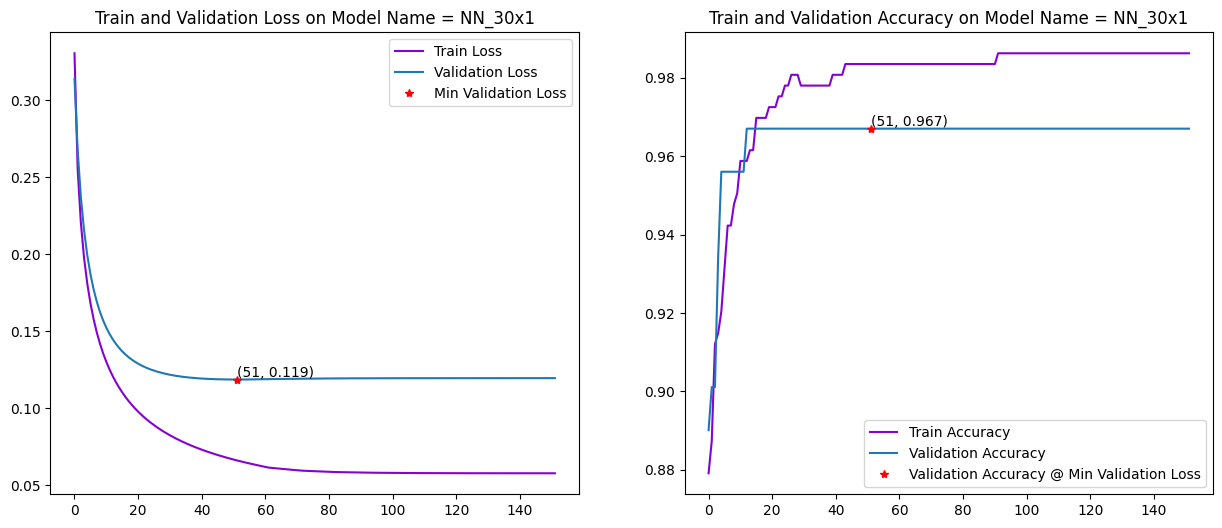

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.06629950553178787,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11876930296421051,
 'Validation Recall': 0.9444444179534912}

In [31]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### First Hidden Layer

##### NN 30x1x1

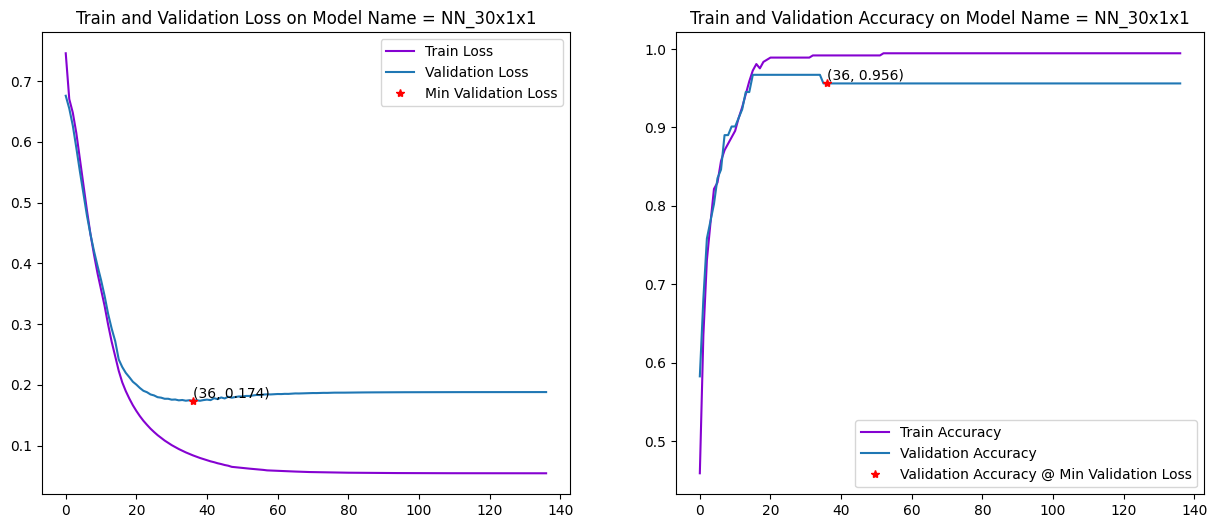

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.08403265476226807,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.17377977073192596,
 'Validation Recall': 0.9444444179534912}

In [32]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x1x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x5x1

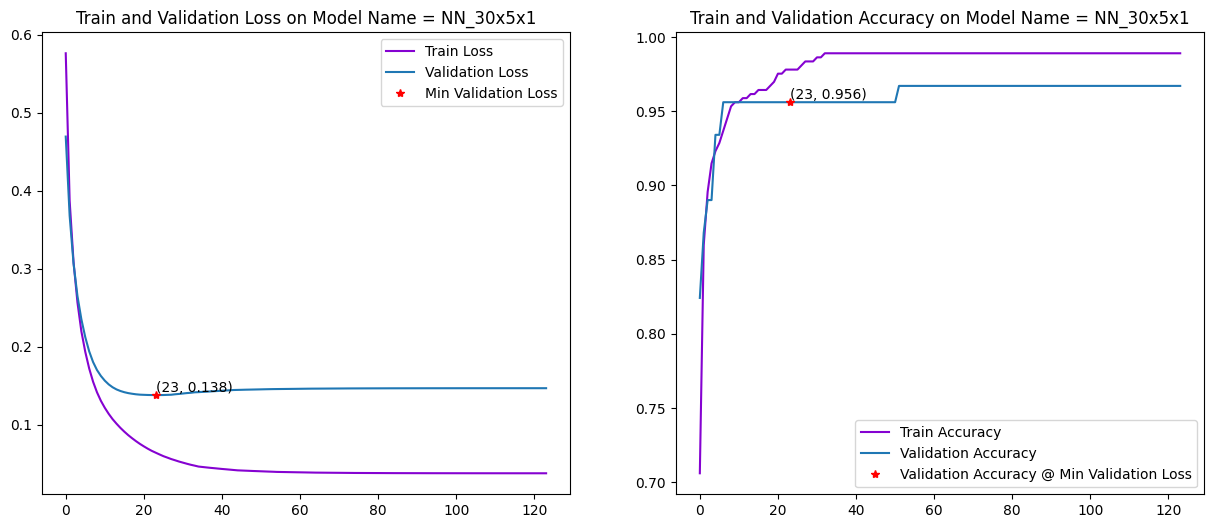

{'Train Accuracy': 0.9780219793319702,
 'Train Loss': 0.06401615589857101,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.13775764405727386,
 'Validation Recall': 0.9444444179534912}

In [33]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x1

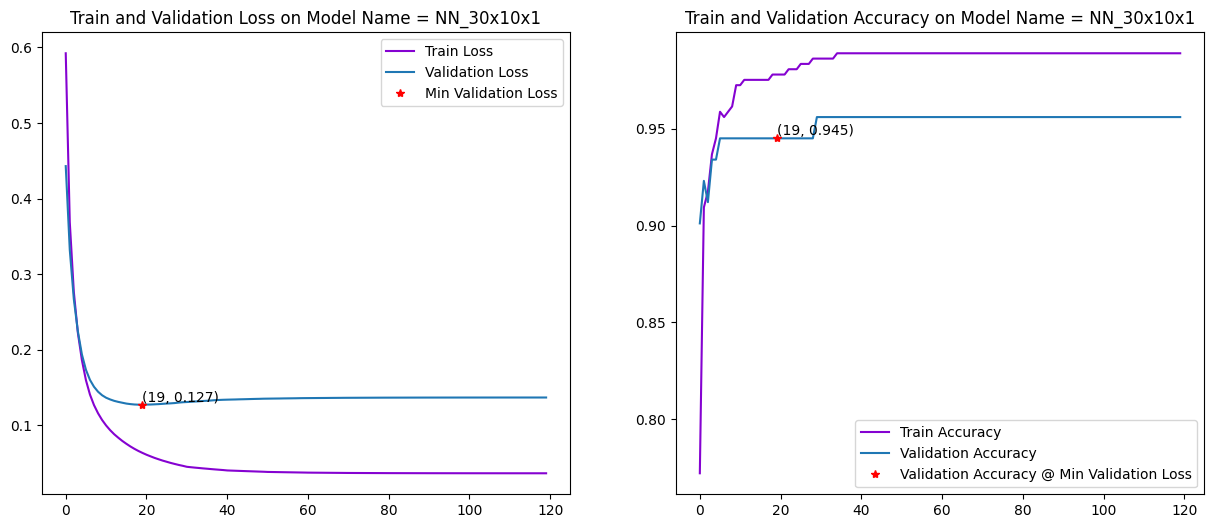

{'Train Accuracy': 0.9780219793319702,
 'Train Loss': 0.06344342231750488,
 'Validation Accuracy': 0.9450549483299255,
 'Validation Loss': 0.1271391212940216,
 'Validation Recall': 0.9444444179534912}

In [34]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x20x1

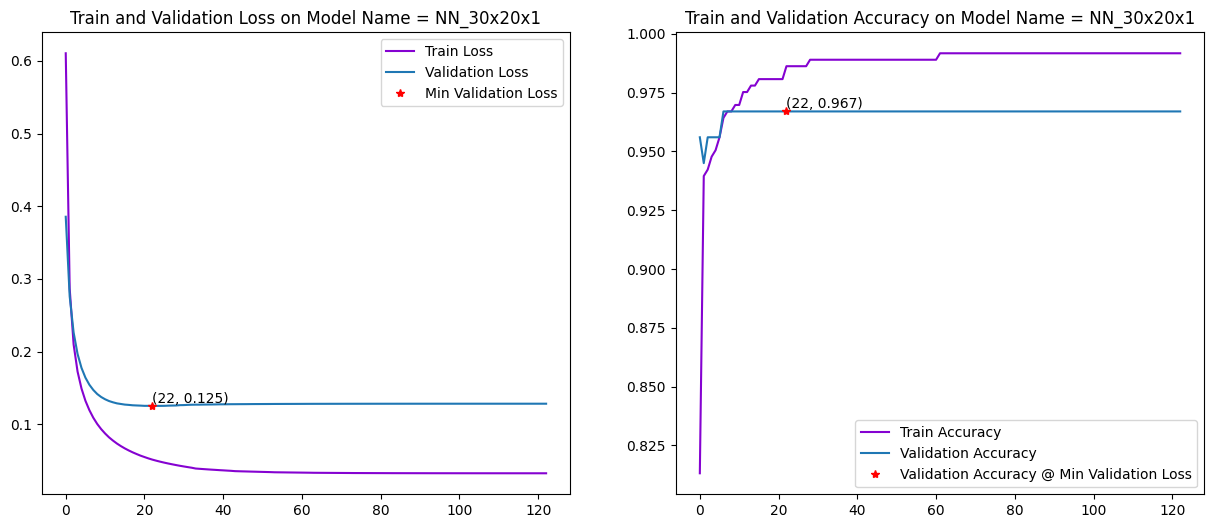

{'Train Accuracy': 0.9862637519836426,
 'Train Loss': 0.05120659992098808,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12510676681995392,
 'Validation Recall': 0.9444444179534912}

In [35]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x20x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x1

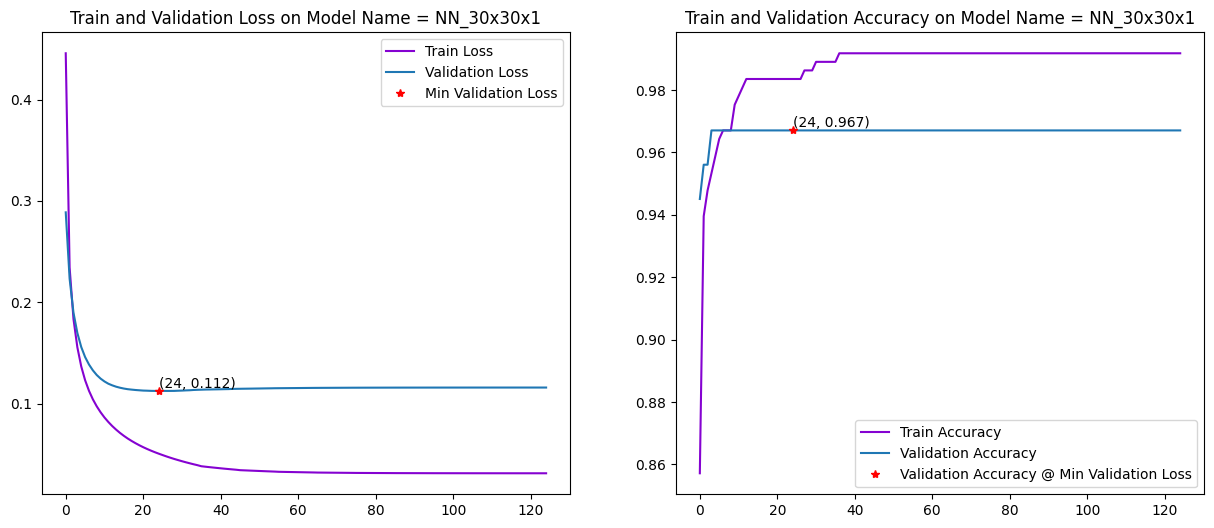

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.050601303577423096,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11246653646230698,
 'Validation Recall': 0.9444444179534912}

In [36]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Concluion: We see that NN_30x30x1 is yields the best results for 1st hidden layer. <br>
We will check what is the best activation function for this layer.

In [37]:
nn_arch_df

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
0     NN_30x1        0.983516    0.066300             0.967033   
1   NN_30x1x1        0.991758    0.084033             0.956044   
2   NN_30x5x1        0.978022    0.064016             0.956044   
3  NN_30x10x1        0.978022    0.063443             0.945055   
4  NN_30x20x1        0.986264    0.051207             0.967033   
5  NN_30x30x1        0.983516    0.050601             0.967033   

   Validation Loss  Validation Recall  
0         0.118769           0.944444  
1         0.173780           0.944444  
2         0.137758           0.944444  
3         0.127139           0.944444  
4         0.125107           0.944444  
5         0.112467           0.944444

#### Activation Functions

##### NN 30x30x1 - leaky_relu

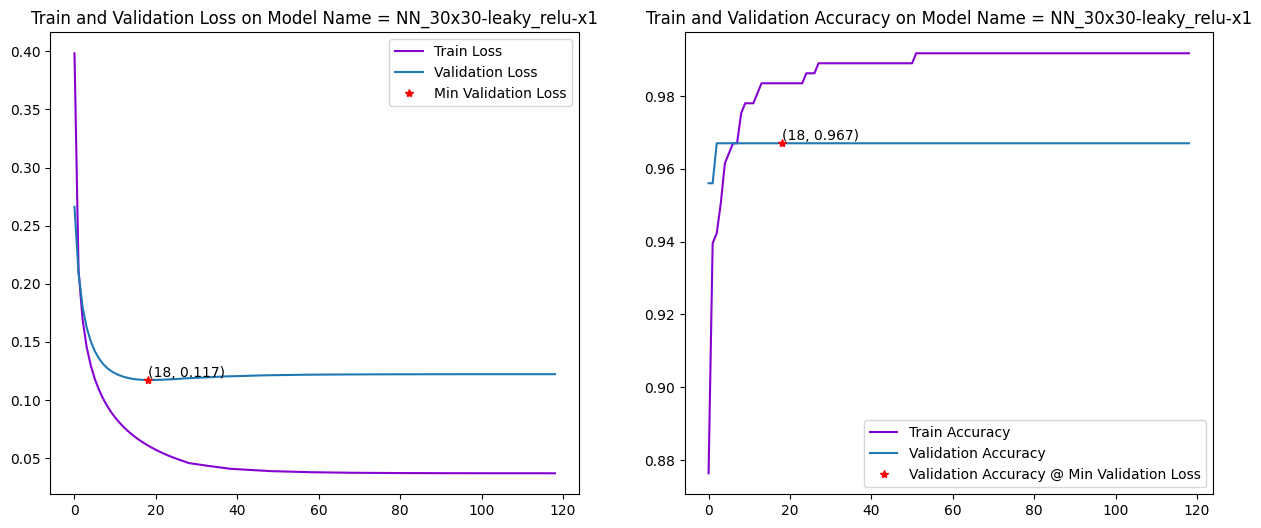

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.06101656332612038,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.1173243448138237,
 'Validation Recall': 0.9444444179534912}

In [38]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30-leaky_relu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='leaky_relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x1 - silu

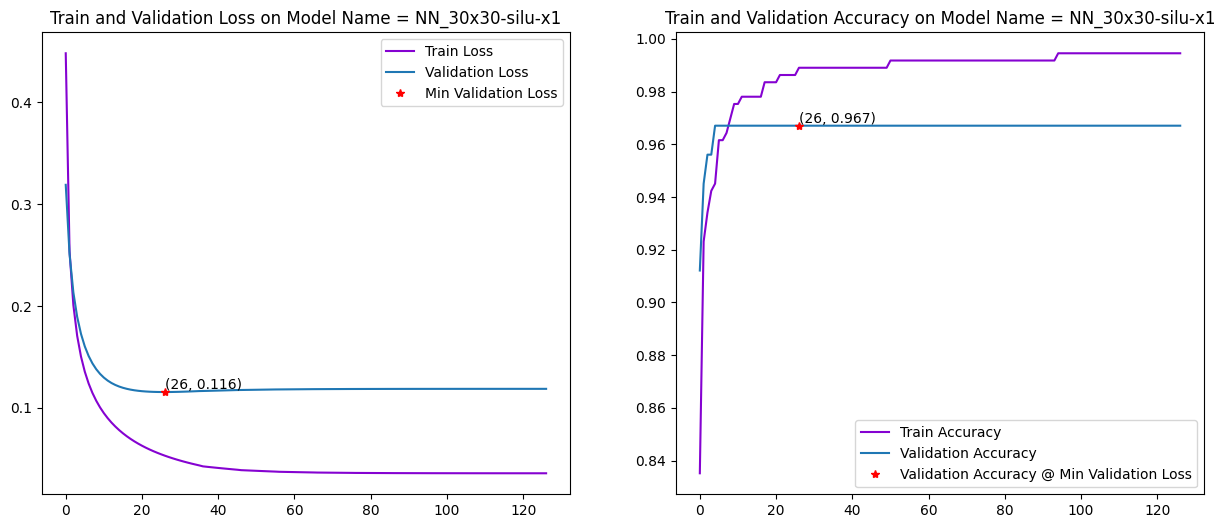

{'Train Accuracy': 0.9890109896659851,
 'Train Loss': 0.05312499403953552,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11559637635946274,
 'Validation Recall': 0.9444444179534912}

In [39]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30-silu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='silu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x1 - elu

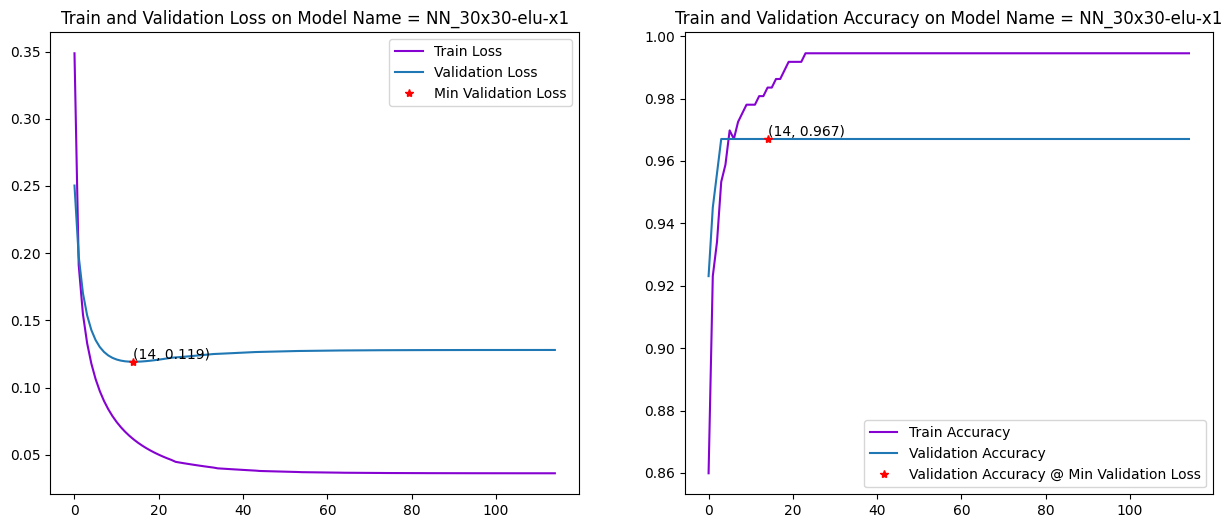

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.06153574958443642,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.1192040741443634,
 'Validation Recall': 0.9444444179534912}

In [40]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30-elu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x1 - tanh

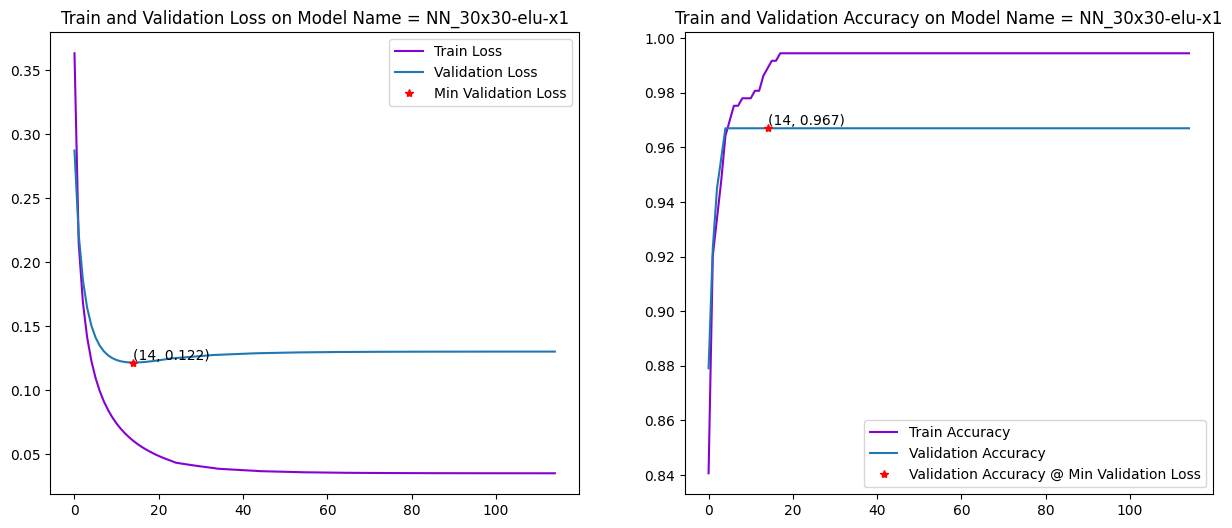

{'Train Accuracy': 0.9890109896659851,
 'Train Loss': 0.06043032929301262,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12169165164232254,
 'Validation Recall': 0.9444444179534912}

In [41]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30-elu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Concluion: We see that relu yields the best results for 1st hidden layer activation function. <br>

##### Second Hidden Layer

##### NN 30x30x1x1

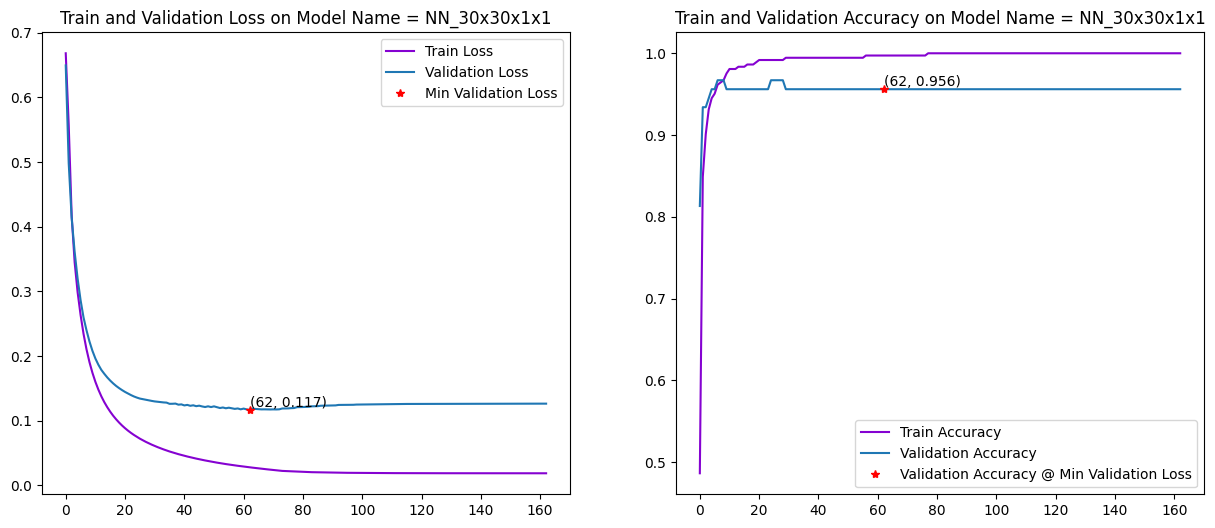

{'Train Accuracy': 0.9972527623176575,
 'Train Loss': 0.027925869449973106,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.11665107309818268,
 'Validation Recall': 0.9444444179534912}

In [42]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x1x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1

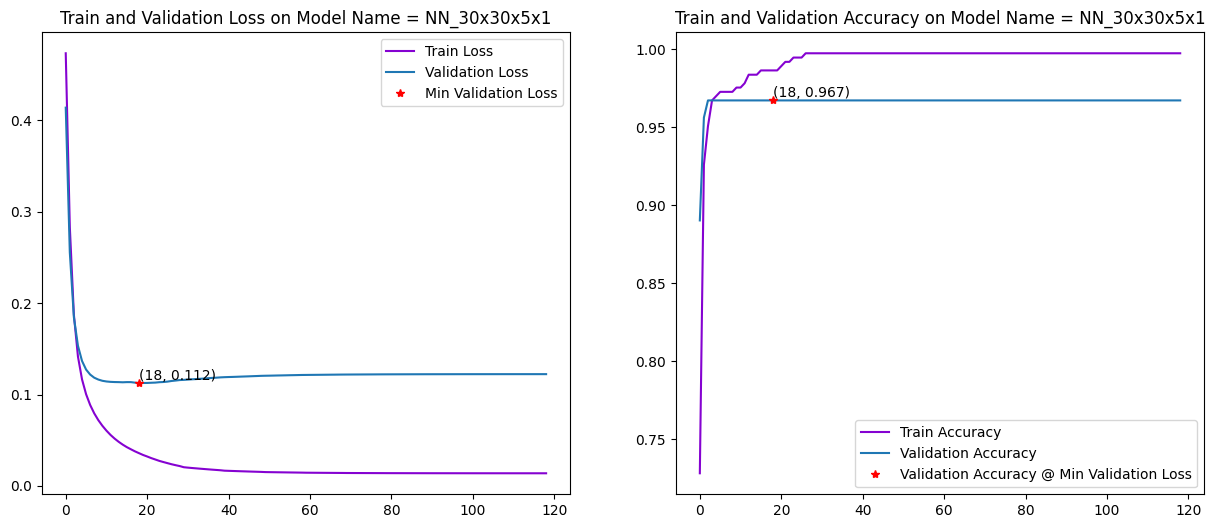

{'Train Accuracy': 0.9862637519836426,
 'Train Loss': 0.03579508513212204,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11245930939912796,
 'Validation Recall': 0.9444444179534912}

In [43]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x10x1

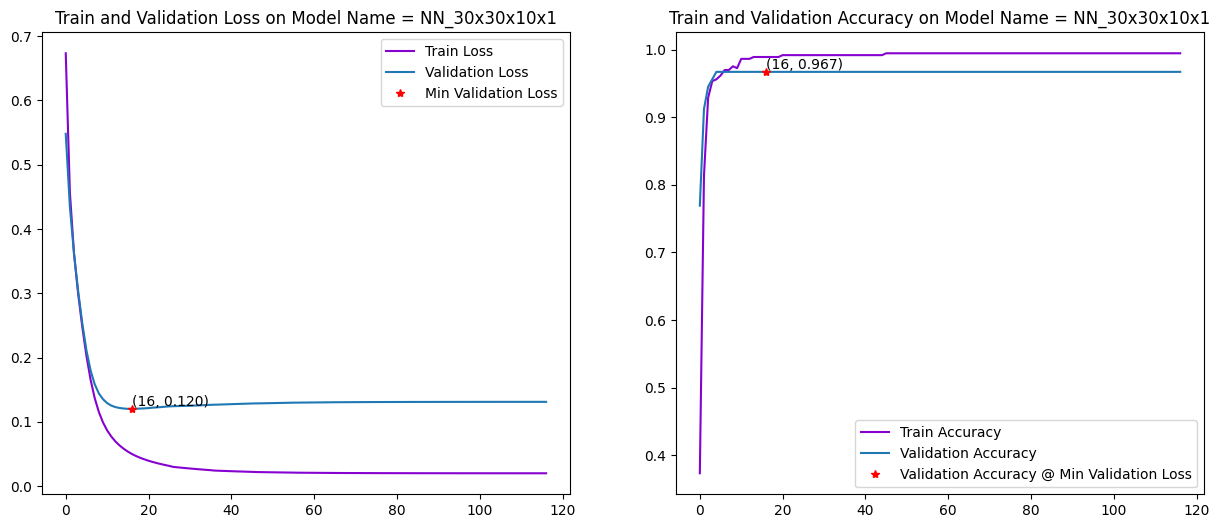

{'Train Accuracy': 0.9890109896659851,
 'Train Loss': 0.049922991544008255,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12019570171833038,
 'Validation Recall': 0.9444444179534912}

In [44]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x10x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x20x1

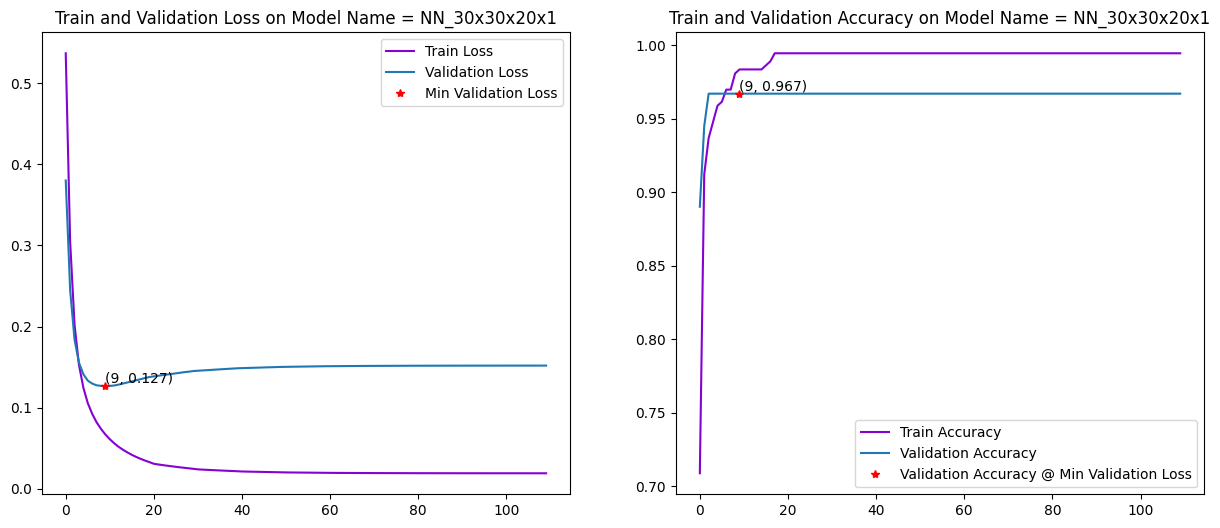

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.06704986840486526,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12672749161720276,
 'Validation Recall': 0.9444444179534912}

In [45]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x20x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x30x1

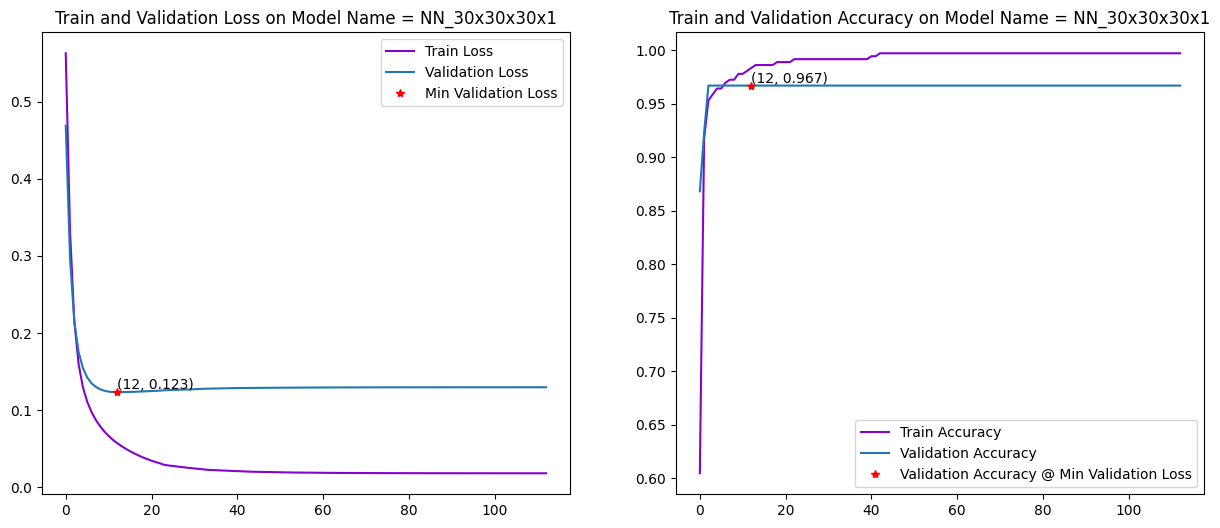

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.057178571820259094,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12313253432512283,
 'Validation Recall': 0.9444444179534912}

In [46]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Concluion: We see that NN_30x30x5x1 is yields the best results for 2st hidden layer. <br>
We will check what is the best activation function for this layer.

In [47]:
nn_arch_df

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
0                  NN_30x1        0.983516    0.066300             0.967033   
1                NN_30x1x1        0.991758    0.084033             0.956044   
2                NN_30x5x1        0.978022    0.064016             0.956044   
3               NN_30x10x1        0.978022    0.063443             0.945055   
4               NN_30x20x1        0.986264    0.051207             0.967033   
5               NN_30x30x1        0.983516    0.050601             0.967033   
6   NN_30x30-leaky_relu-x1        0.983516    0.061017             0.967033   
7         NN_30x30-silu-x1        0.989011    0.053125             0.967033   
8          NN_30x30-elu-x1        0.983516    0.061536             0.967033   
9          NN_30x30-elu-x1        0.989011    0.060430             0.967033   
10            NN_30x30x1x1        0.997253    0.027926             0.956044   
11            NN_30x30x5x1        0.986264    0.035795             0.967033   
12           NN_30x30x10x1        0.989011    0.049923             0.967033   
13           NN_30x30x20x1        0.983516    0.067050             0.967033   
14           NN_30x30x30x1        0.983516    0.057179             0.967033   

    Validation Loss  Validation Recall  
0          0.118769           0.944444  
1          0.173780           0.944444  
2          0.137758           0.944444  
3          0.127139           0.944444  
4          0.125107           0.944444  
5          0.112467           0.944444  
6          0.117324           0.944444  
7          0.115596           0.944444  
8          0.119204           0.944444  
9          0.121692           0.944444  
10         0.116651           0.944444  
11         0.112459           0.944444  
12         0.120196           0.944444  
13         0.126727           0.944444  
14         0.123133           0.944444

#### Activation Functions

##### NN 30x30x5x1 - leaky_relu

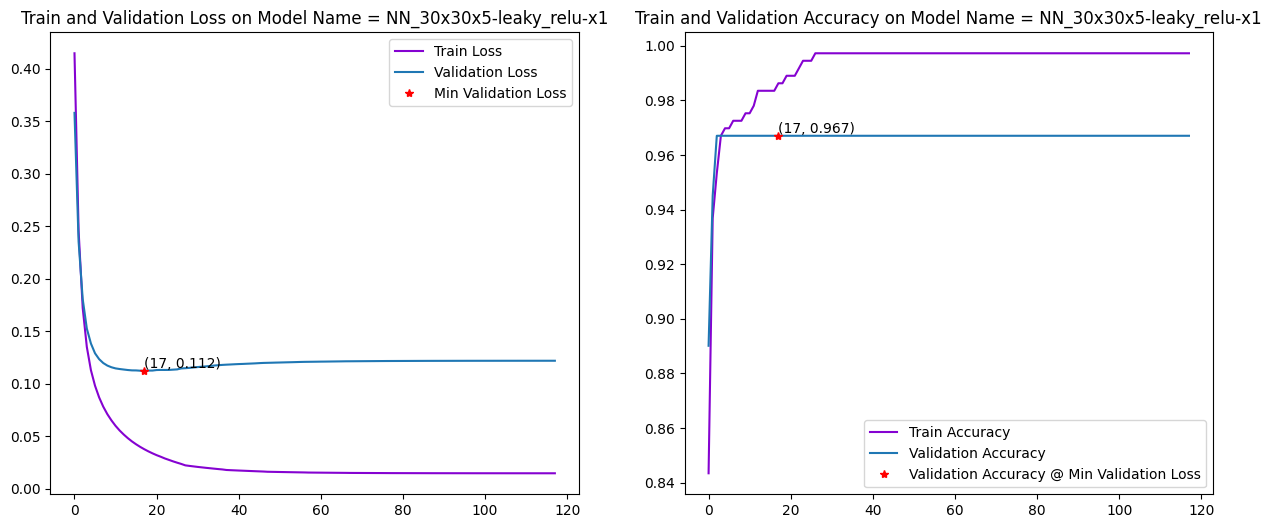

{'Train Accuracy': 0.9862637519836426,
 'Train Loss': 0.0377514585852623,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11239489912986755,
 'Validation Recall': 0.9444444179534912}

In [48]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-leaky_relu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='leaky_relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1 - silu

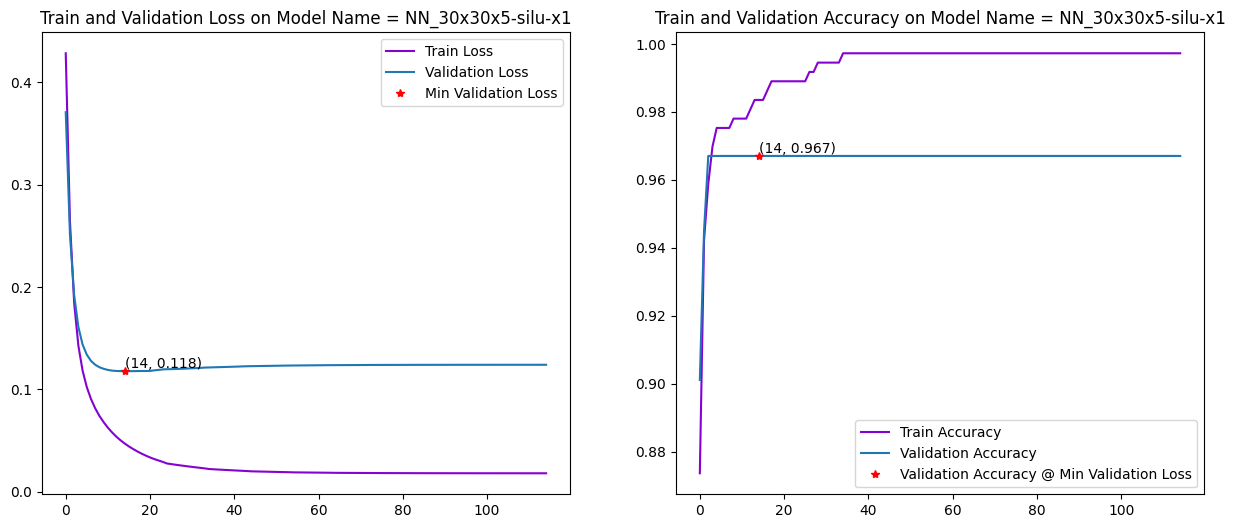

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.04701341316103935,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.1177244707942009,
 'Validation Recall': 0.9444444179534912}

In [49]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-silu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='silu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1 - elu

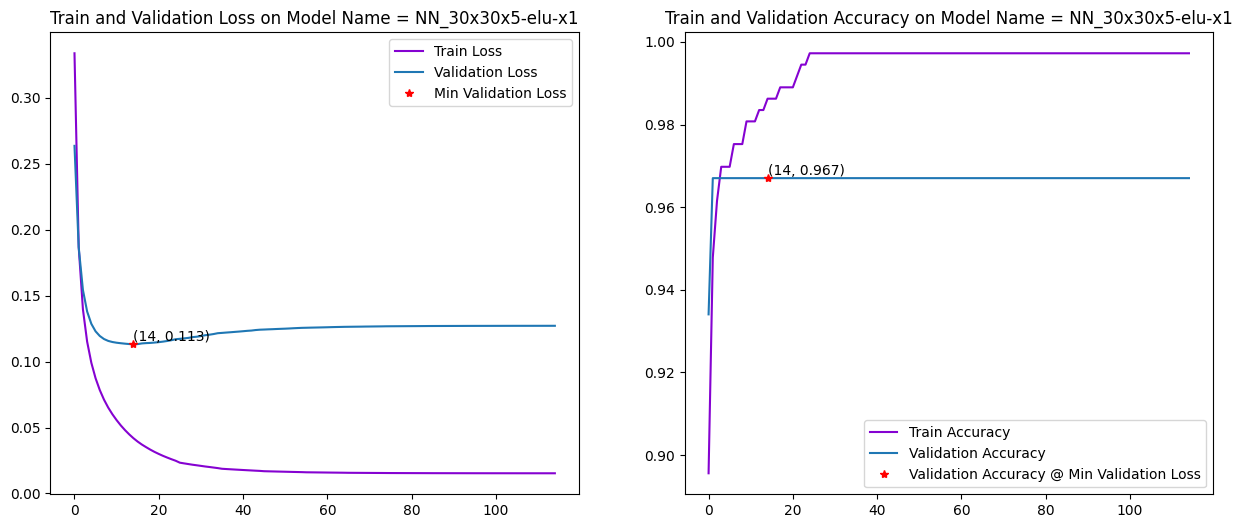

{'Train Accuracy': 0.9862637519836426,
 'Train Loss': 0.04187528416514397,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11314237117767334,
 'Validation Recall': 0.9444444179534912}

In [50]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-elu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1 - tanh

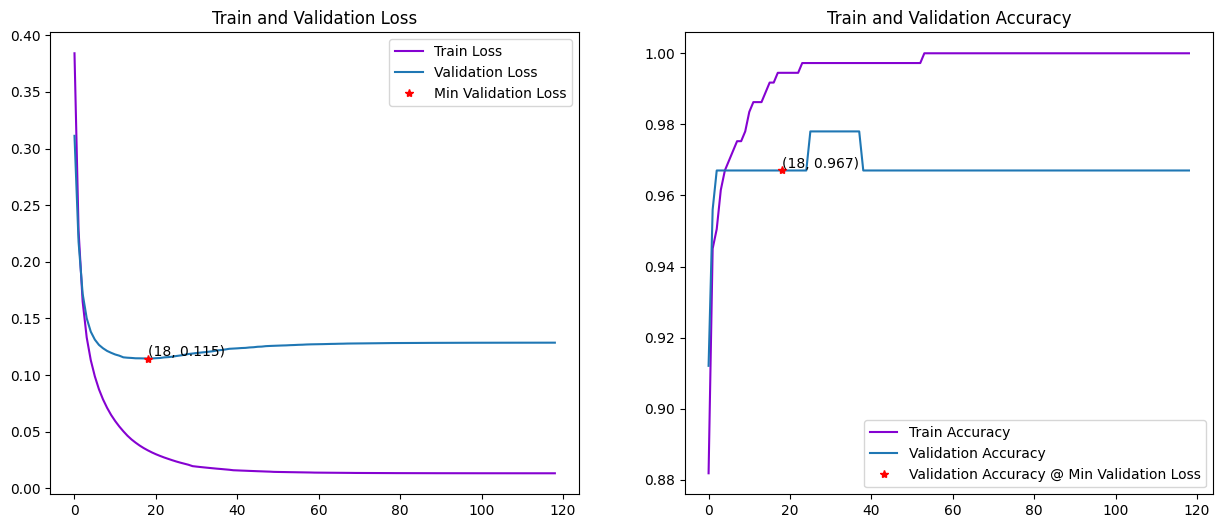

{'Train Accuracy': 0.9945054650306702,
 'Train Loss': 0.033535175025463104,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11456635594367981,
 'Validation Recall': 0.9444444179534912}

In [51]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-tanh-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history)
proc_data

Concluion: We see that relu yields the best results for 2st hidden layer activation function. <br>

In [52]:
nn_arch_df

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
0                    NN_30x1        0.983516    0.066300             0.967033   
1                  NN_30x1x1        0.991758    0.084033             0.956044   
2                  NN_30x5x1        0.978022    0.064016             0.956044   
3                 NN_30x10x1        0.978022    0.063443             0.945055   
4                 NN_30x20x1        0.986264    0.051207             0.967033   
5                 NN_30x30x1        0.983516    0.050601             0.967033   
6     NN_30x30-leaky_relu-x1        0.983516    0.061017             0.967033   
7           NN_30x30-silu-x1        0.989011    0.053125             0.967033   
8            NN_30x30-elu-x1        0.983516    0.061536             0.967033   
9            NN_30x30-elu-x1        0.989011    0.060430             0.967033   
10              NN_30x30x1x1        0.997253    0.027926             0.956044   
11              NN_30x30x5x1        0.986264    0.035795             0.967033   
12             NN_30x30x10x1        0.989011    0.049923             0.967033   
13             NN_30x30x20x1        0.983516    0.067050             0.967033   
14             NN_30x30x30x1        0.983516    0.057179             0.967033   
15  NN_30x30x5-leaky_relu-x1        0.986264    0.037751             0.967033   
16        NN_30x30x5-silu-x1        0.983516    0.047013             0.967033   
17         NN_30x30x5-elu-x1        0.986264    0.041875             0.967033   
18        NN_30x30x5-tanh-x1        0.994505    0.033535             0.967033   

    Validation Loss  Validation Recall  
0          0.118769           0.944444  
1          0.173780           0.944444  
2          0.137758           0.944444  
3          0.127139           0.944444  
4          0.125107           0.944444  
5          0.112467           0.944444  
6          0.117324           0.944444  
7          0.115596           0.944444  
8          0.119204           0.944444  
9          0.121692           0.944444  
10         0.116651           0.944444  
11         0.112459           0.944444  
12         0.120196           0.944444  
13         0.126727           0.944444  
14         0.123133           0.944444  
15         0.112395           0.944444  
16         0.117724           0.944444  
17         0.113142           0.944444  
18         0.114566           0.944444

In [53]:
nn_arch_df.sort_values(by='Validation Loss')

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
15  NN_30x30x5-leaky_relu-x1        0.986264    0.037751             0.967033   
11              NN_30x30x5x1        0.986264    0.035795             0.967033   
5                 NN_30x30x1        0.983516    0.050601             0.967033   
17         NN_30x30x5-elu-x1        0.986264    0.041875             0.967033   
18        NN_30x30x5-tanh-x1        0.994505    0.033535             0.967033   
7           NN_30x30-silu-x1        0.989011    0.053125             0.967033   
10              NN_30x30x1x1        0.997253    0.027926             0.956044   
6     NN_30x30-leaky_relu-x1        0.983516    0.061017             0.967033   
16        NN_30x30x5-silu-x1        0.983516    0.047013             0.967033   
0                    NN_30x1        0.983516    0.066300             0.967033   
8            NN_30x30-elu-x1        0.983516    0.061536             0.967033   
12             NN_30x30x10x1        0.989011    0.049923             0.967033   
9            NN_30x30-elu-x1        0.989011    0.060430             0.967033   
14             NN_30x30x30x1        0.983516    0.057179             0.967033   
4                 NN_30x20x1        0.986264    0.051207             0.967033   
13             NN_30x30x20x1        0.983516    0.067050             0.967033   
3                 NN_30x10x1        0.978022    0.063443             0.945055   
2                  NN_30x5x1        0.978022    0.064016             0.956044   
1                  NN_30x1x1        0.991758    0.084033             0.956044   

    Validation Loss  Validation Recall  
15         0.112395           0.944444  
11         0.112459           0.944444  
5          0.112467           0.944444  
17         0.113142           0.944444  
18         0.114566           0.944444  
7          0.115596           0.944444  
10         0.116651           0.944444  
6          0.117324           0.944444  
16         0.117724           0.944444  
0          0.118769           0.944444  
8          0.119204           0.944444  
12         0.120196           0.944444  
9          0.121692           0.944444  
14         0.123133           0.944444  
4          0.125107           0.944444  
13         0.126727           0.944444  
3          0.127139           0.944444  
2          0.137758           0.944444  
1          0.173780           0.944444

Conclusion: We can see that the Network Architecture of 30x30x5x1 yields the best results, while a leaky-relu or relu activation function in the second hidden layer yields the same results, thus we will remain with the default activation function. <br>
We will check this network with KFolds.

In [54]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=1000, batchSize=32, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Validation Accuracy Mean: 0.06956134364008904, Validation Accuracy STD: 0.026920619367968576
Validation Loss Mean: 0.06956134364008904, Validation Loss STD: 0.026920619367968576


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.991758    0.021987             0.978022         0.038784   
1  1        0.986264    0.041378             0.945055         0.104022   
2  2        0.989011    0.031768             0.978022         0.046750   
3  3        0.997253    0.018031             0.978022         0.084637   
4  4        0.994505    0.017029             0.967033         0.073614   

   Validation Recall  
0           1.000000  
1           0.941176  
2           0.970588  
3           0.941176  
4           0.970588

<b><u>Conclusion:</u></b> We can see that the 30x30x5x1 is the Network Architecture that yields the best and stable results. <br>
With that said, we will also still take the SLP, which is the basic Network Architecture (No hidden layers) into consideration.

In [55]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

#### Batch-Size

------------------------------------------------------------------------------------------------------------------
Batch Size = 1


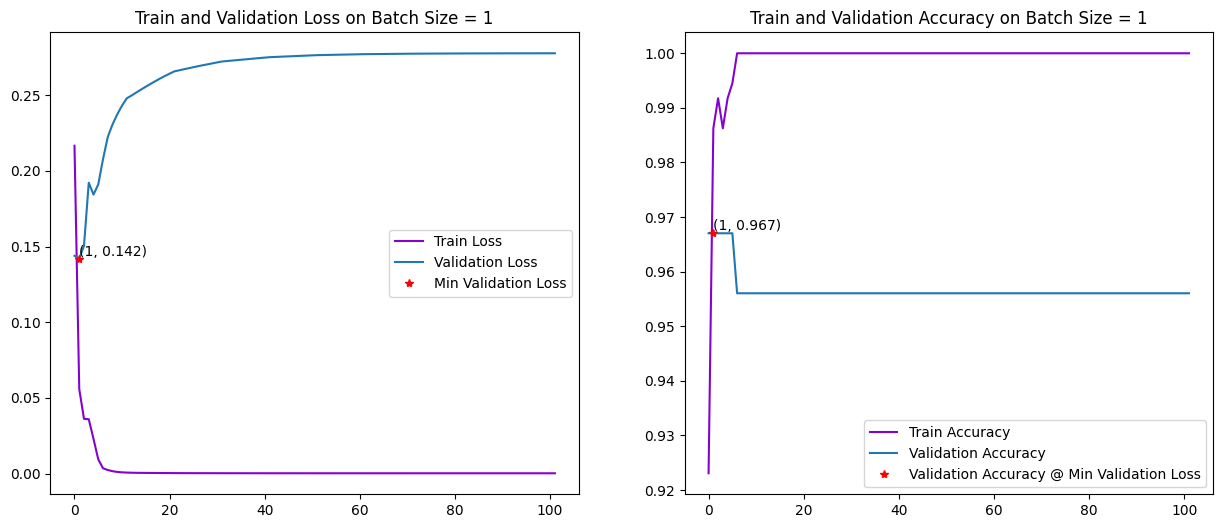

------------------------------------------------------------------------------------------------------------------
Batch Size = 2


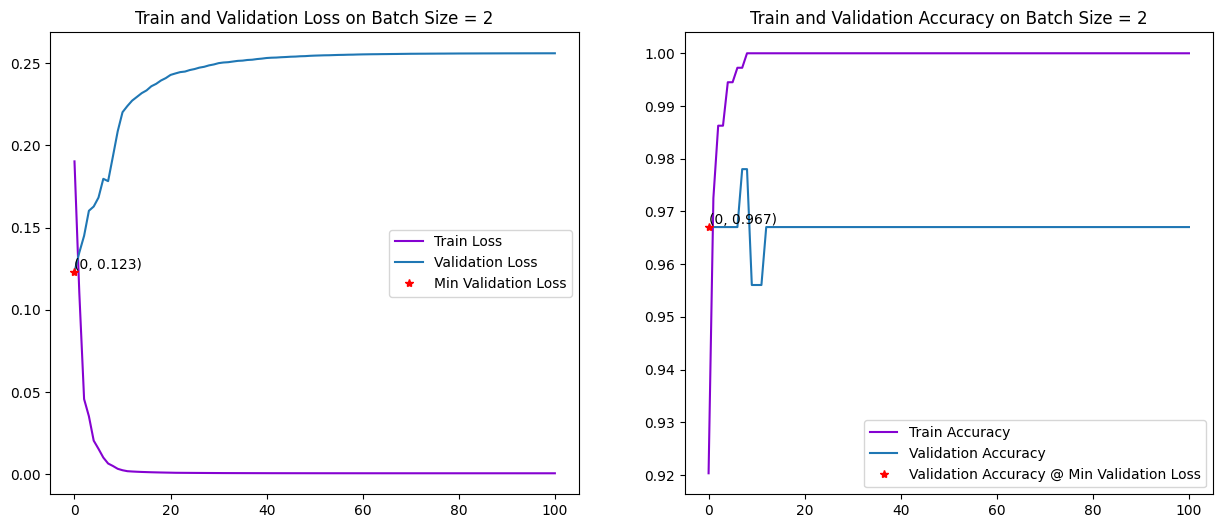

------------------------------------------------------------------------------------------------------------------
Batch Size = 4


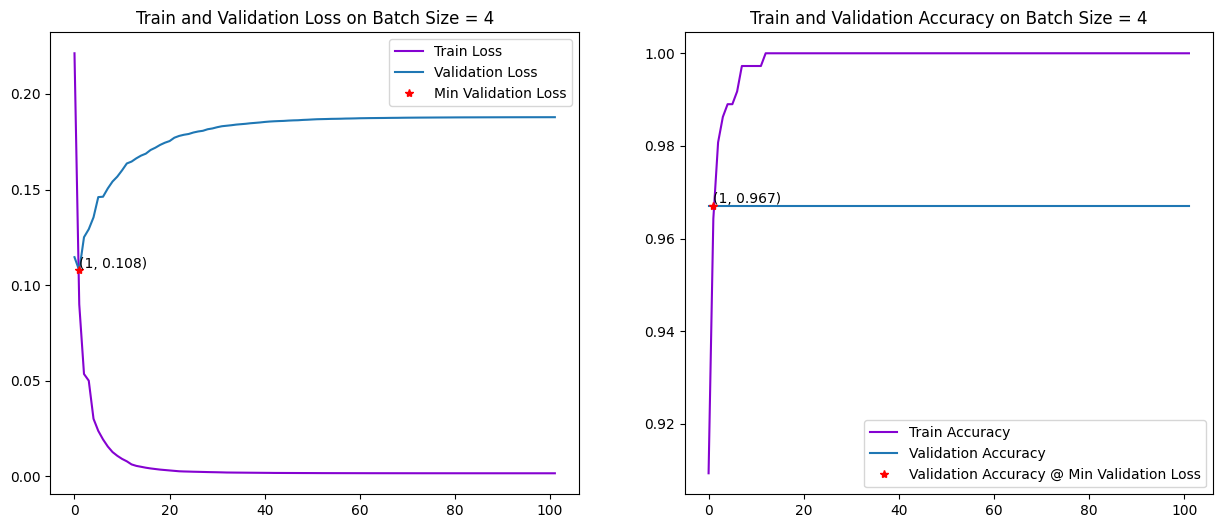

------------------------------------------------------------------------------------------------------------------
Batch Size = 8


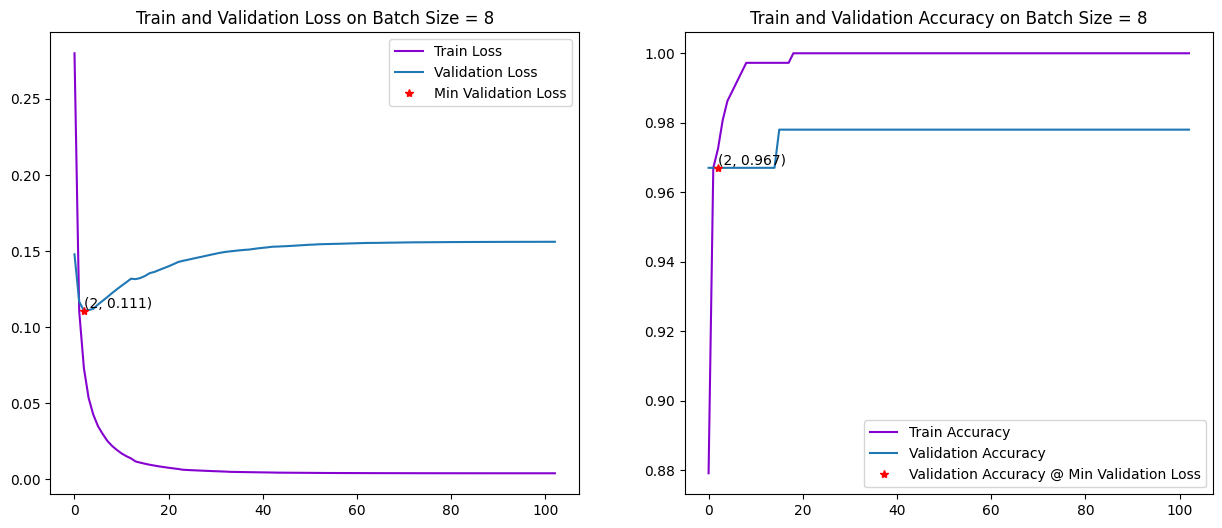

------------------------------------------------------------------------------------------------------------------
Batch Size = 16


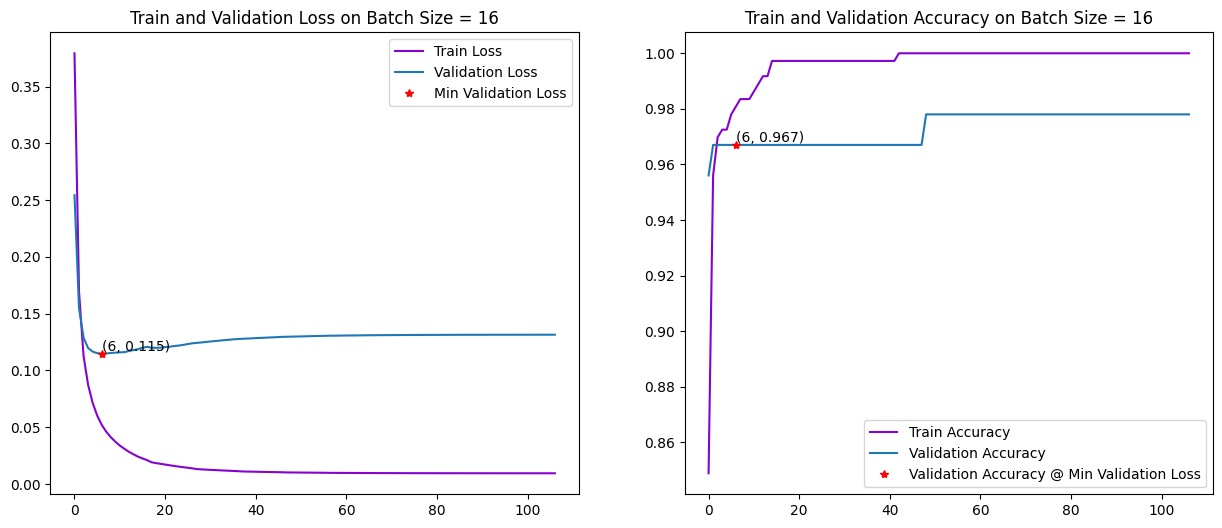

------------------------------------------------------------------------------------------------------------------
Batch Size = 32


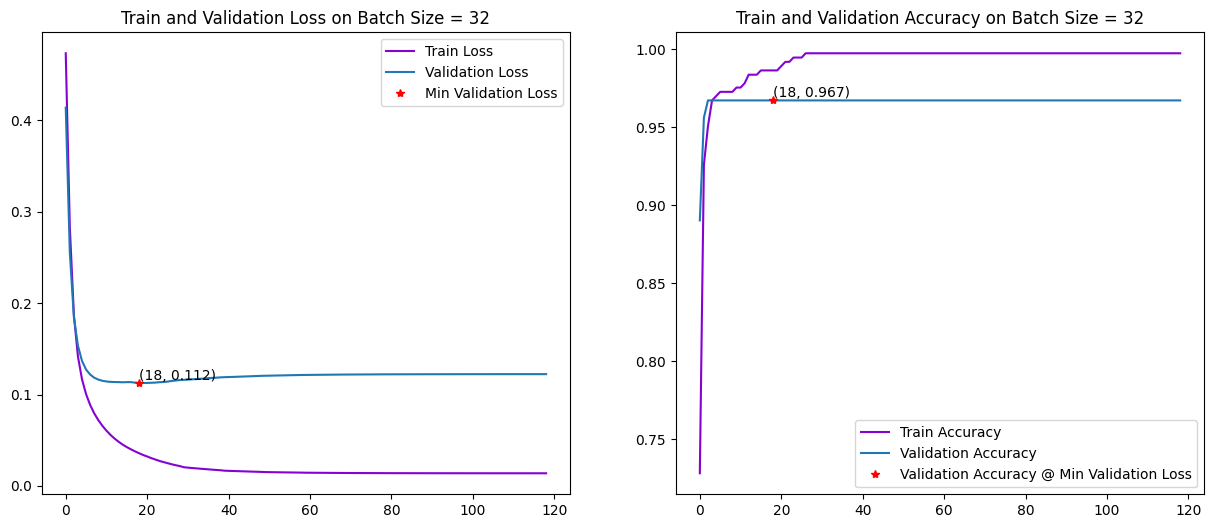

------------------------------------------------------------------------------------------------------------------
Batch Size = 64


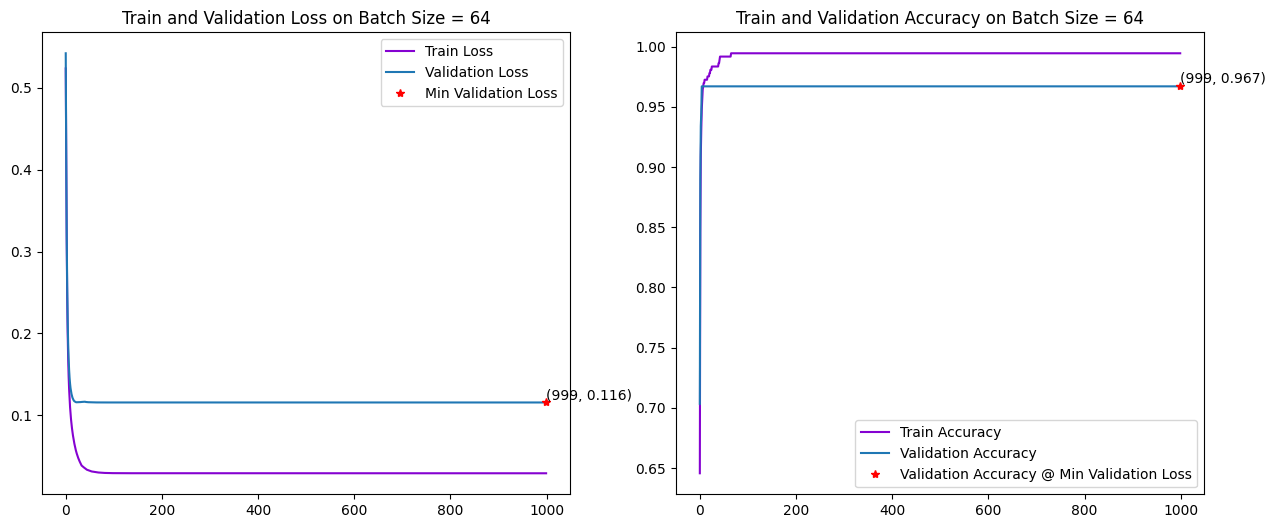

------------------------------------------------------------------------------------------------------------------
Batch Size = 128


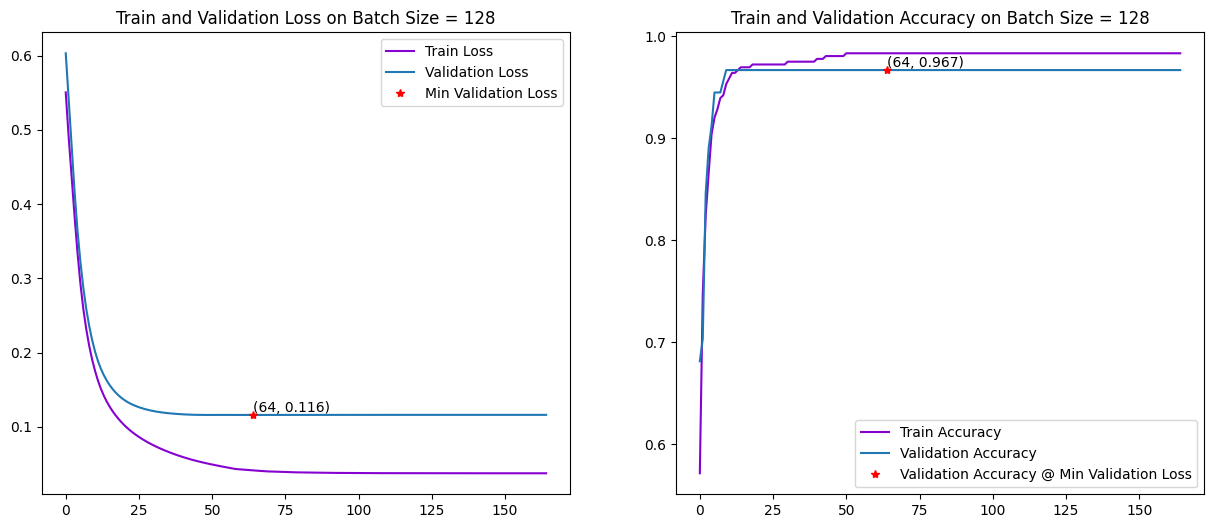

In [56]:
df_batch_size = pd.DataFrame(columns=['Batch Size', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

model = models.clone_model(BEST_MODEL)

for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Batch Size = {batch_size}')    
        
    model.set_weights(BEST_MODEL.get_weights())   

    history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=batch_size, en_early_stopping=True, en_reduce_lr=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Batch Size': batch_size, **proc_data}
    df_batch_size.loc[len(df_batch_size)] = new_row
    model_history(history, f'Batch Size = {batch_size}')


In [57]:
for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    model.set_weights(BEST_MODEL.get_weights())
    batch_size_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=1000, batchSize=batch_size, en_reduce_lr=True, en_early_stopping=True, verbose=0)
    print('----------------------------------------------------------------------------------------------------')
    print(f'Batch Size = {batch_size}')
    print(f"Validation Loss Mean: {batch_size_res_df['Validation Loss'].mean()}, Validation Loss STD: {batch_size_res_df['Validation Loss'].std()}")    
    print(f"Validation Recall Mean: {batch_size_res_df['Validation Recall'].mean()}, Validation Recall STD: {batch_size_res_df['Validation Recall'].std()}")    
    print(batch_size_res_df)    


----------------------------------------------------------------------------------------------------
Batch Size = 1
Validation Loss Mean: 0.10003550946712494, Validation Loss STD: 0.03726733893926623
Validation Recall Mean: 0.970588231086731, Validation Recall STD: 0.029411762952807587
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.920330    0.171626             0.967033         0.092426   
1  1        0.967033    0.102589             0.956044         0.150797   
2  2        0.983516    0.053702             0.978022         0.052570   
3  3        0.967033    0.074915             0.978022         0.084047   
4  4        0.986264    0.044492             0.945055         0.120338   

   Validation Recall  
0           1.000000  
1           0.941176  
2           1.000000  
3           0.970588  
4           0.941176  
----------------------------------------------------------------------------------------------------
Batch Size = 2
Validation Los

In [58]:
df_batch_size

Batch Size  Train Accuracy  Train Loss  Validation Accuracy  \
0           1        0.986264    0.055821             0.967033   
1           2        0.920330    0.190239             0.967033   
2           4        0.964286    0.089983             0.967033   
3           8        0.972527    0.073013             0.967033   
4          16        0.980769    0.052192             0.967033   
5          32        0.986264    0.035795             0.967033   
6          64        0.994505    0.029101             0.967033   
7         128        0.983516    0.041245             0.967033   

   Validation Loss  Validation Recall  
0         0.142031           0.944444  
1         0.123105           0.944444  
2         0.107666           0.944444  
3         0.110896           0.944444  
4         0.114909           0.944444  
5         0.112459           0.944444  
6         0.115607           0.944444  
7         0.115903           0.944444

Conclusion: As we can see from the results, BATCH_SIZE = 8 yielded the best results in the Validation Loss (mean), <br> 
As well as over the recall metric in the 5 folds. Thus, we will choose BATCH_SIZE = 8 as the best BATCH_SIZE.

In [18]:
BEST_BATCH_SIZE = 8

## Handling Overfitting

### Dropout

In [21]:
nn_drop_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### Input Layer Dropout

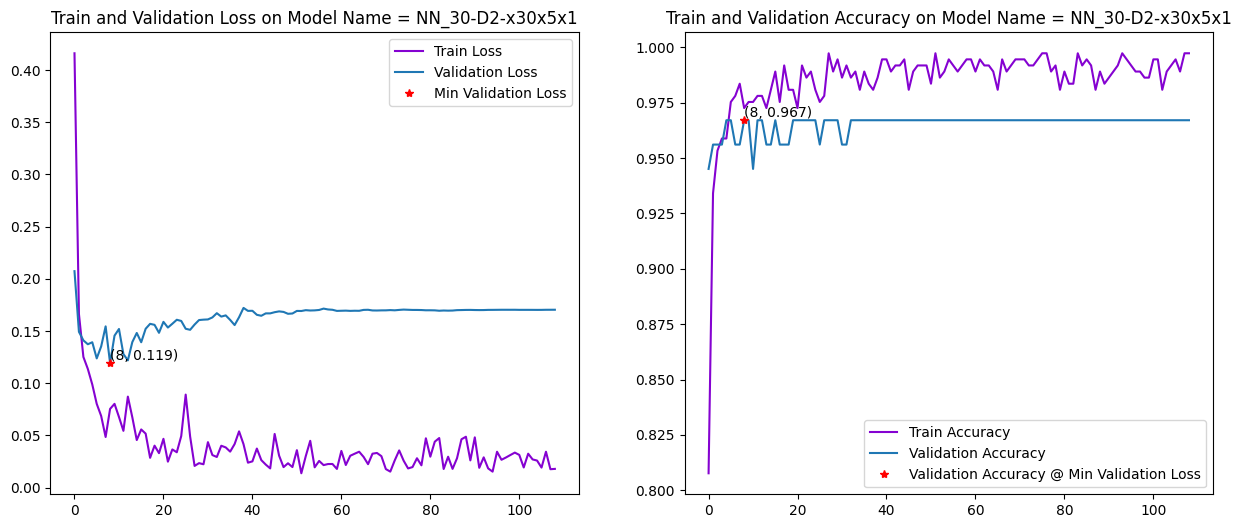

{'Train Accuracy': 0.9725274443626404,
 'Train Loss': 0.07537493109703064,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11937391757965088,
 'Validation Recall': 0.9444444179534912}

In [22]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30-D2-x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First Layer Dropout

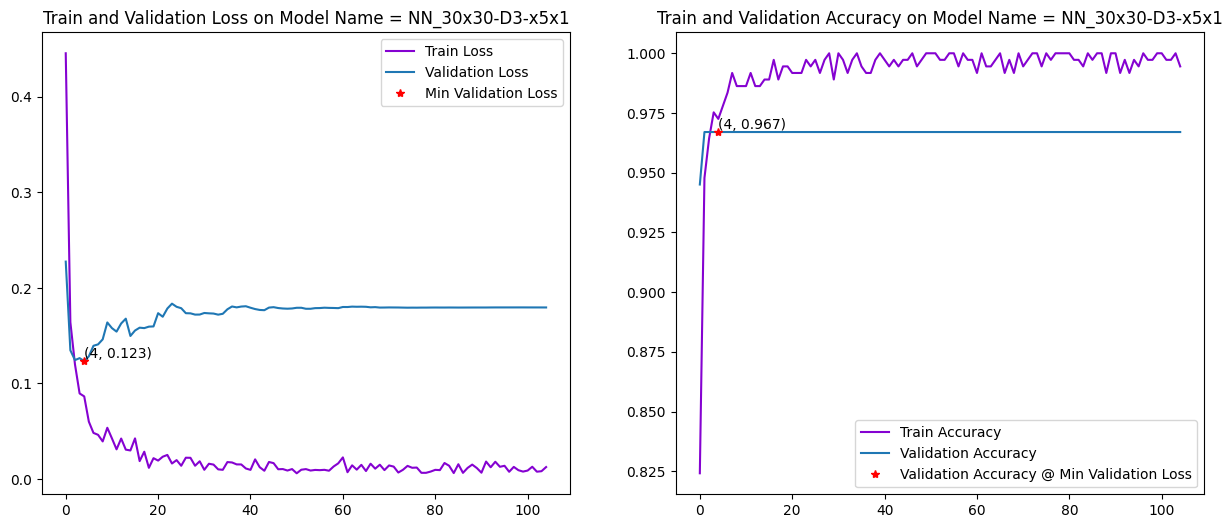

{'Train Accuracy': 0.9725274443626404,
 'Train Loss': 0.08644508570432663,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12342137843370438,
 'Validation Recall': 0.9444444179534912}

In [23]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Second Layer Dropout

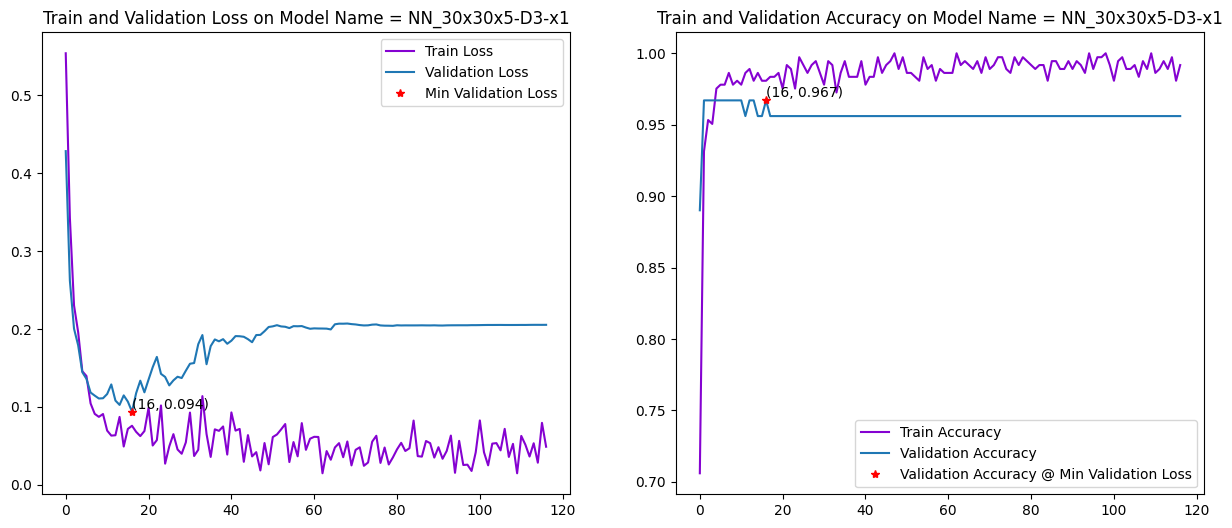

{'Train Accuracy': 0.9807692170143127,
 'Train Loss': 0.0757845789194107,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.09403028339147568,
 'Validation Recall': 0.9444444179534912}

In [24]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First & Second Layer Dropout

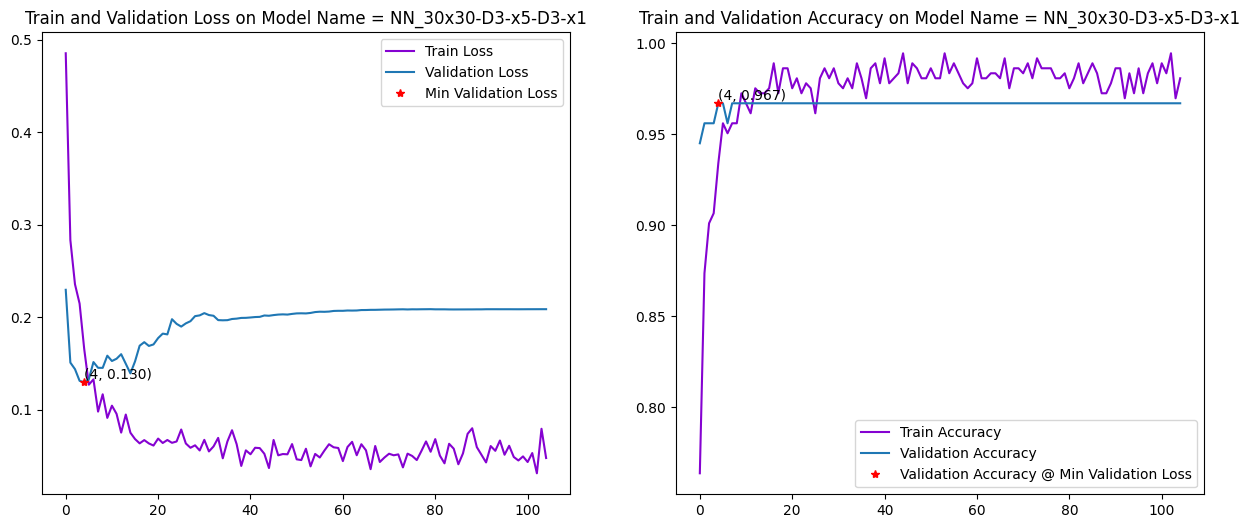

{'Train Accuracy': 0.9340659379959106,
 'Train Loss': 0.16548334062099457,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12957321107387543,
 'Validation Recall': 0.9444444179534912}

In [25]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### KFold Assessment

In [26]:
nn_drop_df

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
0      NN_30-D2-x30x5x1        0.972527    0.075375             0.967033   
1      NN_30x30-D3-x5x1        0.972527    0.086445             0.967033   
2      NN_30x30x5-D3-x1        0.980769    0.075785             0.967033   
3  NN_30x30-D3-x5-D3-x1        0.934066    0.165483             0.967033   

   Validation Loss  Validation Recall  
0         0.119374           0.944444  
1         0.123421           0.944444  
2         0.094030           0.944444  
3         0.129573           0.944444

##### Input Layer Dropout Assessment

In [66]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30-D2-x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.06502523235976695, Validation Accuracy STD: 0.04747156738525238
Validation Loss Mean: 0.06502523235976695, Validation Loss STD: 0.04747156738525238
Validation Recall Mean: 0.9764705777168274, Validation Recall STD: 0.024607649934571398


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.983516    0.037279             0.978022         0.048407   
1  1        0.961538    0.116562             0.956044         0.147000   
2  2        0.983516    0.044718             1.000000         0.023335   
3  3        0.964286    0.073054             0.989011         0.053326   
4  4        0.986264    0.038089             0.978022         0.053059   

   Validation Recall  
0           1.000000  
1           0.941176  
2           1.000000  
3           0.970588  
4           0.970588

##### First Layer Dropout Assessment

In [67]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.06985601671040058, Validation Accuracy STD: 0.04146456872083384
Validation Loss Mean: 0.06985601671040058, Validation Loss STD: 0.04146456872083384
Validation Recall Mean: 0.970588231086731, Validation Recall STD: 0.029411762952807587


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.986264    0.024559             1.000000         0.026879   
1  1        0.975275    0.090664             0.956044         0.113908   
2  2        0.967033    0.086189             0.989011         0.029814   
3  3        0.972527    0.068982             0.978022         0.108406   
4  4        0.983516    0.041178             0.978022         0.070274   

   Validation Recall  
0           1.000000  
1           0.941176  
2           1.000000  
3           0.941176  
4           0.970588

##### Second Layer Dropout Assessment

In [68]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.05231713689863682, Validation Accuracy STD: 0.019382950683447114
Validation Loss Mean: 0.05231713689863682, Validation Loss STD: 0.019382950683447114
Validation Recall Mean: 0.9823529243469238, Validation Recall STD: 0.01610950234865005


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.972527    0.100224             0.989011         0.037980   
1  1        0.986264    0.063441             0.989011         0.077525   
2  2        0.975275    0.097716             0.989011         0.028407   
3  3        0.989011    0.076943             0.978022         0.060431   
4  4        0.994505    0.047569             0.989011         0.057243   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.970588  
4           0.970588

##### First & Second Layer Dropout Assessment

In [69]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.07936578132212162, Validation Accuracy STD: 0.04254852447941441
Validation Loss Mean: 0.07936578132212162, Validation Loss STD: 0.04254852447941441
Validation Recall Mean: 0.970588219165802, Validation Recall STD: 0.03602191800178134


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.983516    0.076936             0.978022         0.043265   
1  1        0.967033    0.096203             0.978022         0.114350   
2  2        0.964286    0.115024             0.989011         0.028797   
3  3        0.964286    0.104286             0.967033         0.125476   
4  4        0.958791    0.111166             0.967033         0.084941   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.911765  
4           0.970588

#### Tune Dropout Rate = [0.1, 0.2, 0.3, 0.4, 0.5]

In [70]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

for rate in [0.1, 0.2, 0.3, 0.4, 0.5]:

    print('-----------------------------------------------------------------------------')
    print(f'Dropout Rate = {rate}')

    model = models.Sequential(name=f'NN_30x30x5-D{int(rate*10)}-x1')

    model.add(layers.Input((30,)))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
    print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
    print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
    print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
    print(res_df)

-----------------------------------------------------------------------------
Dropout Rate = 0.1
Validation Accuracy Mean: 0.05206255167722702, Validation Accuracy STD: 0.021325790868825224
Validation Loss Mean: 0.05206255167722702, Validation Loss STD: 0.021325790868825224
Validation Recall Mean: 0.9823529243469238, Validation Recall STD: 0.01610950234865005
   k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.997253    0.023653             0.989011         0.036052   
1  1        0.986264    0.050263             0.978022         0.082040   
2  2        0.991758    0.037671             0.989011         0.028916   
3  3        0.989011    0.056546             0.989011         0.063221   
4  4        0.989011    0.041882             0.989011         0.050084   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.970588  
4           0.970588  
-------------------------------------------------------

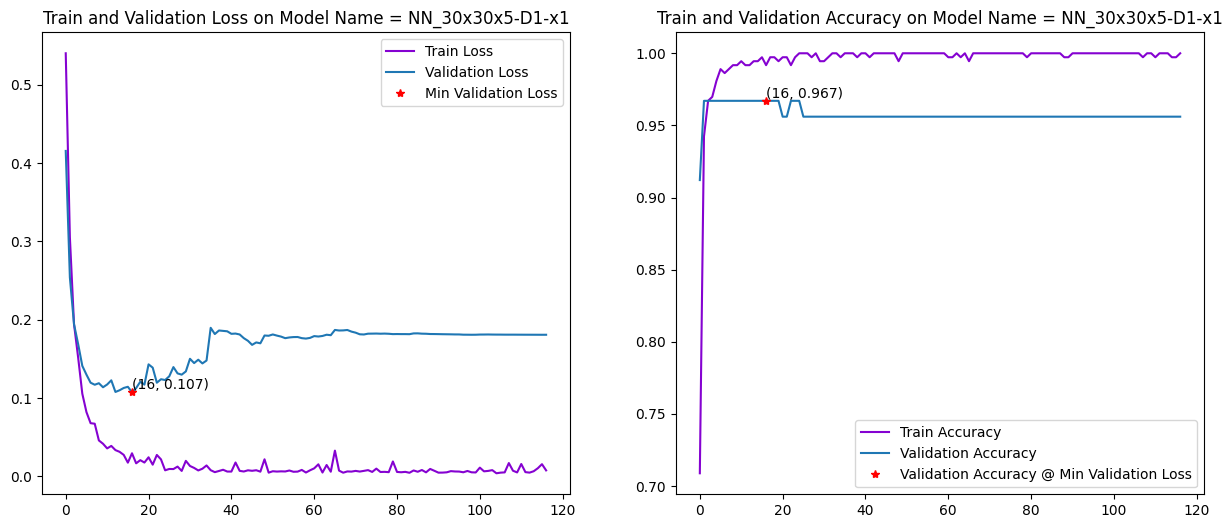

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.029428262263536453,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.10728903859853745,
 'Validation Recall': 0.9444444179534912}

In [71]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Conclusion: We chose the best Dropout Addition to the Network as a Dropout to the Second Layer only with a rate of 0.1. <br>
Thus, we will update our BEST_MODEL.

In [72]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

### L2

In [73]:
nn_l2_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### First Layer L2

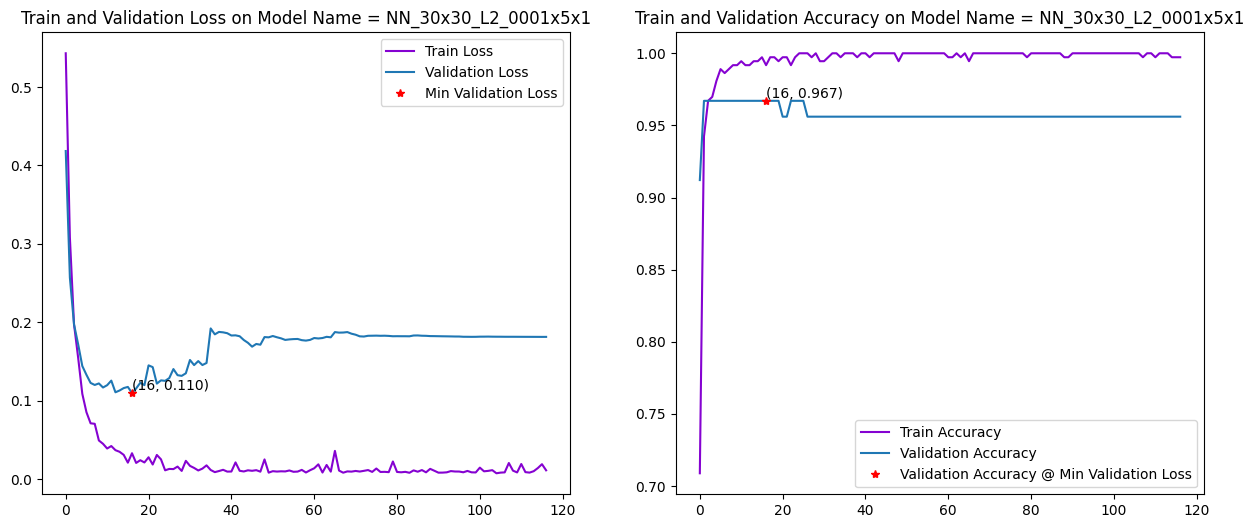

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.03292136266827583,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.1097625344991684,
 'Validation Recall': 0.9444444179534912}

In [74]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L2_0001x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l2_df.loc[len(nn_l2_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Second Layer L2

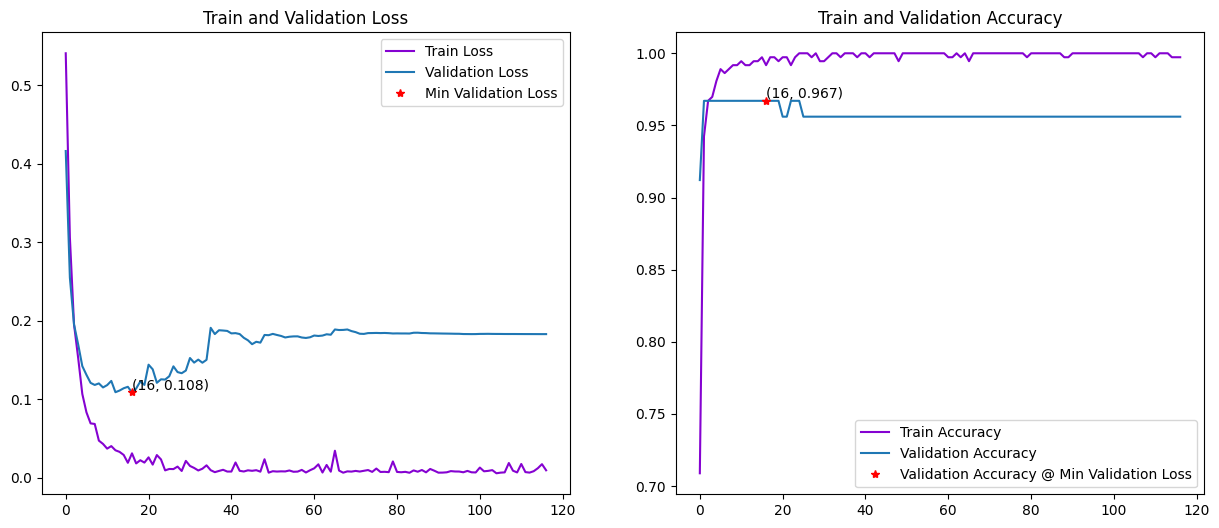

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.030868053436279297,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.10848357528448105,
 'Validation Recall': 0.9444444179534912}

In [75]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5_L2_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l2_df.loc[len(nn_l2_df)] = new_row

model_history(history)
proc_data

#### First & Second Layer L2

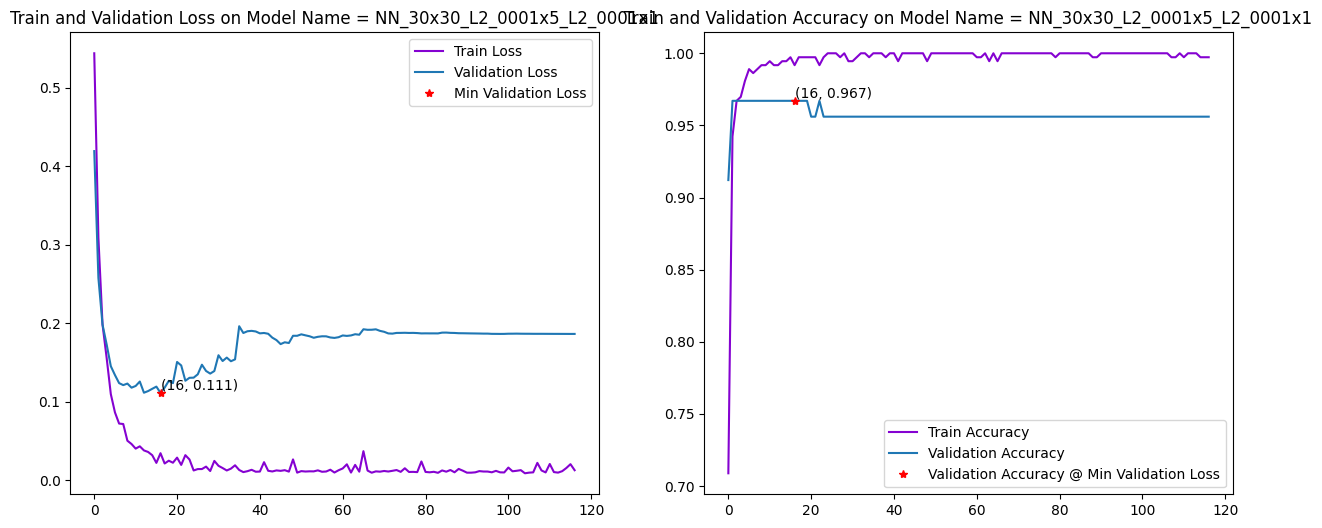

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.03449458256363869,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.11130355298519135,
 'Validation Recall': 0.9444444179534912}

In [76]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L2_0001x5_L2_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l2_df.loc[len(nn_l2_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

In [77]:
nn_l2_df

Model Name  Train Accuracy  Train Loss  \
0          NN_30x30_L2_0001x5x1        0.991758    0.032921   
1          NN_30x30x5_L2_0001x1        0.991758    0.030868   
2  NN_30x30_L2_0001x5_L2_0001x1        0.991758    0.034495   

   Validation Accuracy  Validation Loss  Validation Recall  
0             0.967033         0.109763           0.944444  
1             0.967033         0.108484           0.944444  
2             0.967033         0.111304           0.944444

Conclusion: As we can see, adding the Regularization L2 didn't improve our model performance. <br>
Now we will check how L1 Regularization affects our model.

### L1

In [78]:
nn_l1_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### First Layer L1

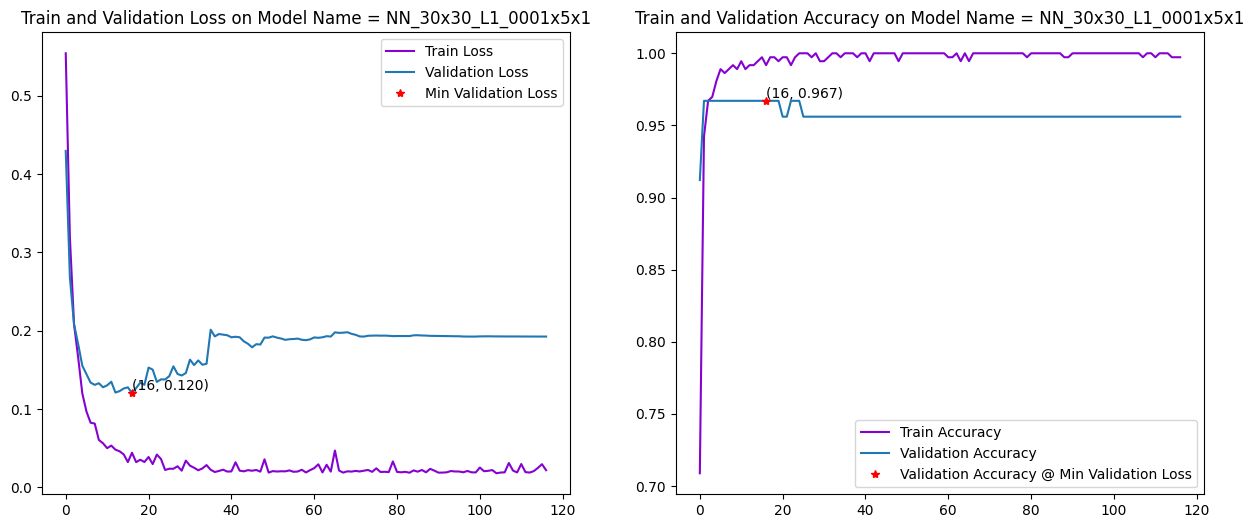

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.04411769285798073,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.12022502720355988,
 'Validation Recall': 0.9444444179534912}

In [79]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L1_0001x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l1_df.loc[len(nn_l1_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Second Layer L1

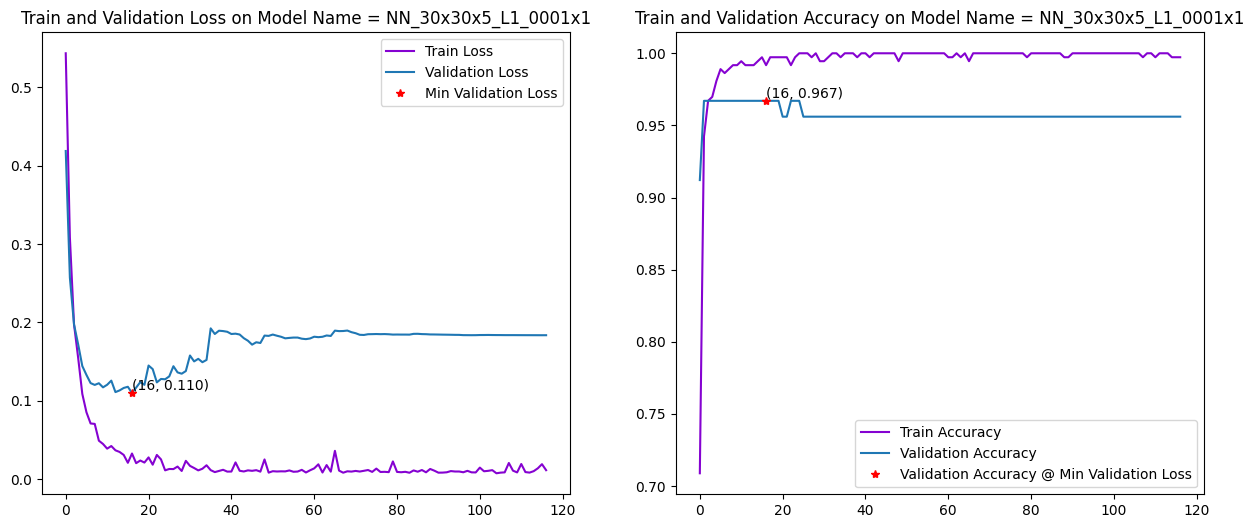

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.03296295553445816,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.110135518014431,
 'Validation Recall': 0.9444444179534912}

In [80]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5_L1_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l1_df.loc[len(nn_l1_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First & Second Layer L1

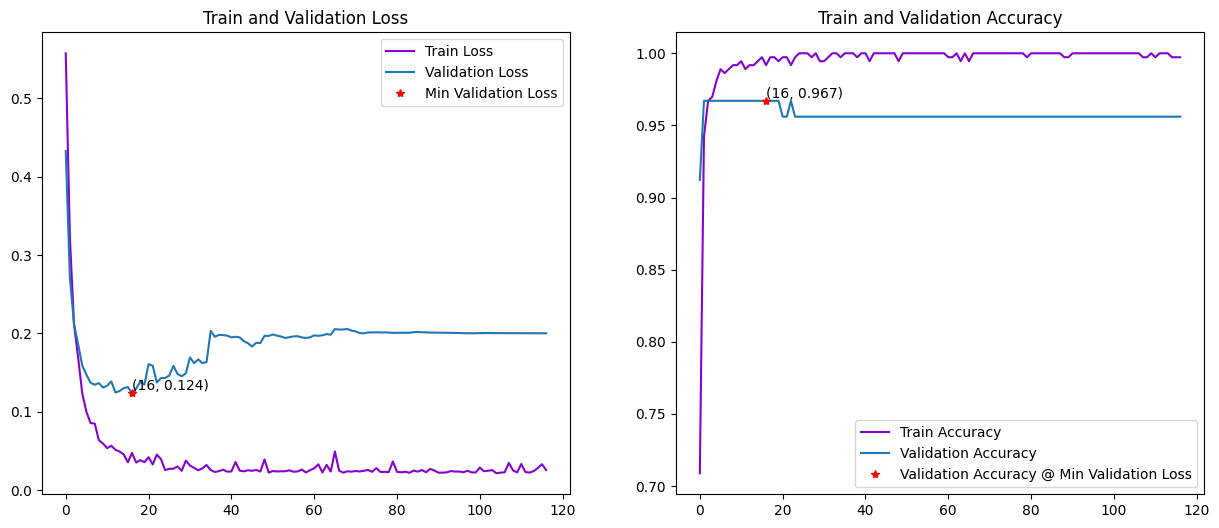

{'Train Accuracy': 0.9917582273483276,
 'Train Loss': 0.04776386171579361,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.1237683966755867,
 'Validation Recall': 0.9444444179534912}

In [81]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L2_0001x5_L1_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l1_df.loc[len(nn_l1_df)] = new_row

model_history(history)
proc_data

In [82]:
nn_l1_df

Model Name  Train Accuracy  Train Loss  \
0          NN_30x30_L1_0001x5x1        0.991758    0.044118   
1          NN_30x30x5_L1_0001x1        0.991758    0.032963   
2  NN_30x30_L2_0001x5_L1_0001x1        0.991758    0.047764   

   Validation Accuracy  Validation Loss  Validation Recall  
0             0.967033         0.120225           0.944444  
1             0.967033         0.110136           0.944444  
2             0.967033         0.123768           0.944444

Conclusion: As we can see, adding the Regularization L1 also didn't improve our model performance. <br>
Thus, we will not use L2 nor L1 Regularizations.

In [83]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

### Bottleneck

In [84]:
nn_bottleneck_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### Bottleneck between Input and First Layers

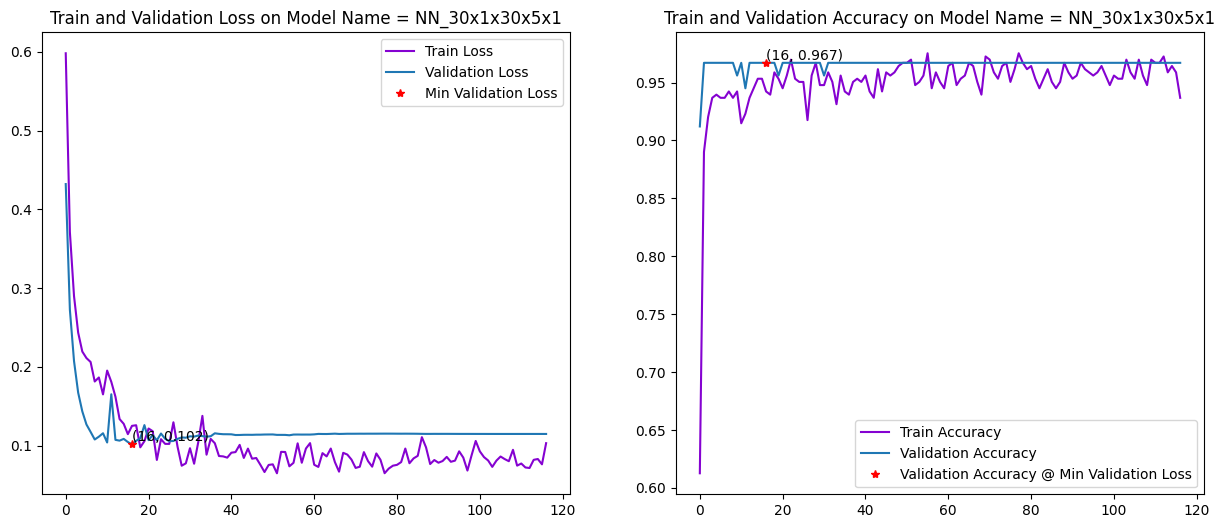

{'Train Accuracy': 0.942307710647583,
 'Train Loss': 0.12518474459648132,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.10166273266077042,
 'Validation Recall': 0.9444444179534912}

In [85]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x1x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Bottleneck between First and Second Layers

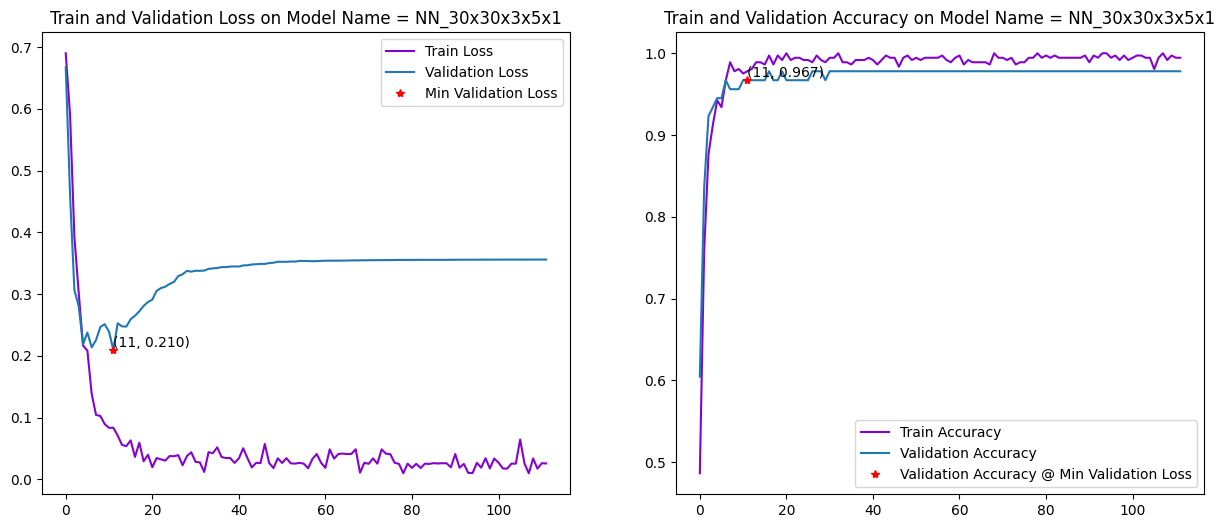

{'Train Accuracy': 0.9780219793319702,
 'Train Loss': 0.08343726396560669,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.20963092148303986,
 'Validation Recall': 0.9444444179534912}

In [86]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x3x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

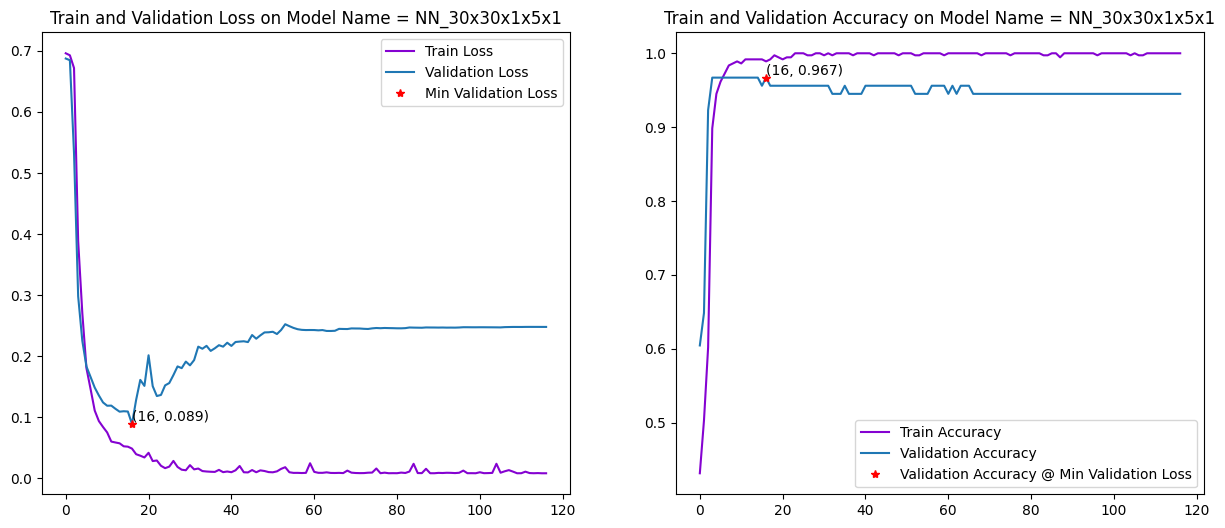

{'Train Accuracy': 0.9890109896659851,
 'Train Loss': 0.048855263739824295,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.08924289047718048,
 'Validation Recall': 0.9444444179534912}

In [87]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x1x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Bottleneck as First Layer

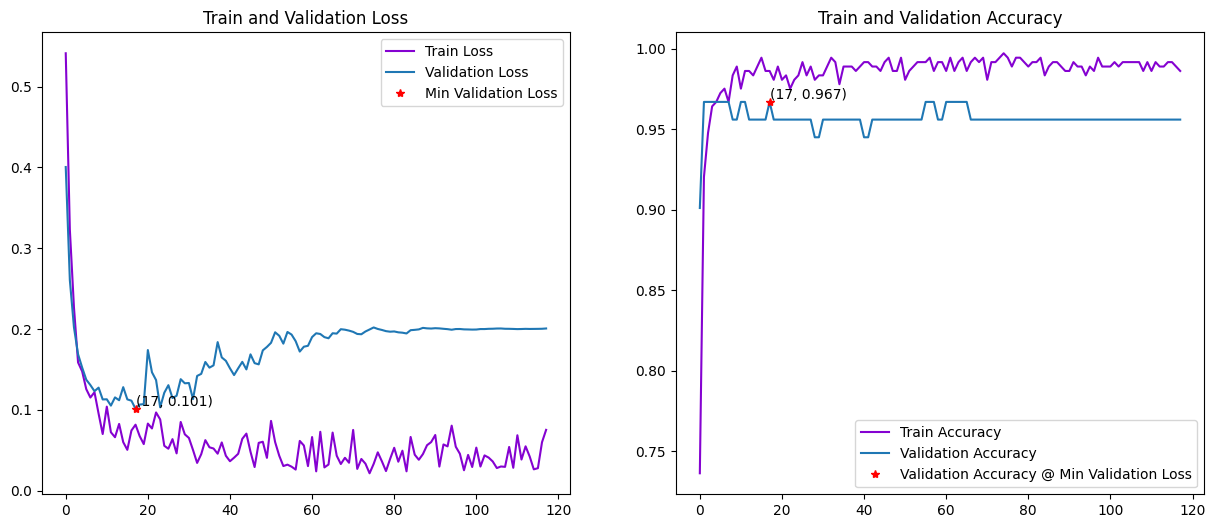

{'Train Accuracy': 0.9862637519836426,
 'Train Loss': 0.08171163499355316,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.10141449421644211,
 'Validation Recall': 0.9444444179534912}

In [88]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x1x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history)
proc_data

In [89]:
nn_bottleneck_df

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
0  NN_30x1x30x5x1        0.942308    0.125185             0.967033   
1  NN_30x30x3x5x1        0.978022    0.083437             0.967033   
2  NN_30x30x1x5x1        0.989011    0.048855             0.967033   
3     NN_30x1x5x1        0.986264    0.081712             0.967033   

   Validation Loss  Validation Recall  
0         0.101663           0.944444  
1         0.209631           0.944444  
2         0.089243           0.944444  
3         0.101414           0.944444

#### KFold Assessment

In [90]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x1x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.07366448193788529, Validation Accuracy STD: 0.030002320626384183
Validation Loss Mean: 0.07366448193788529, Validation Loss STD: 0.030002320626384183
Validation Recall Mean: 0.970588219165802, Validation Recall STD: 0.03602191800178134


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.983516    0.068936             0.989011         0.053535   
1  1        0.961538    0.135110             0.989011         0.069642   
2  2        0.983516    0.080237             0.989011         0.060655   
3  3        0.997253    0.029169             0.989011         0.058191   
4  4        0.991758    0.054685             0.945055         0.126300   

   Validation Recall  
0           1.000000  
1           0.970588  
2           1.000000  
3           0.970588  
4           0.911765

Conclusion: We will not continue with bottleneck when we check other parameters, <br>
However, we will try to see the results of this model on the X_test dataset lateron, because we see that this model could have potential due to its stable graph.

In [91]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

### Batch Normalization

In [117]:
nn_batchnorm_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### First Layer Batch Normalization

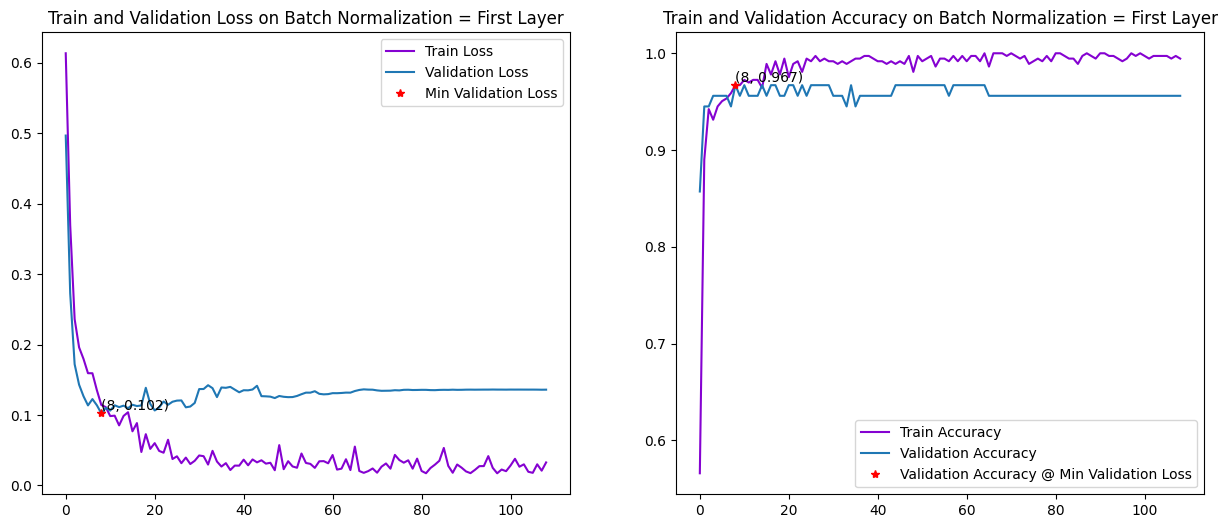

{'Train Accuracy': 0.9670329689979553, 'Train Loss': 0.11421049386262894, 'Validation Accuracy': 0.9670329689979553, 'Validation Loss': 0.10238304734230042, 'Validation Recall': 0.9166666865348816}


In [118]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-BN-x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_batchnorm_df.loc[len(nn_batchnorm_df)] = new_row

model_history(history, f'Batch Normalization = First Layer')
print(proc_data)

#### Second Layer Batch Normalization

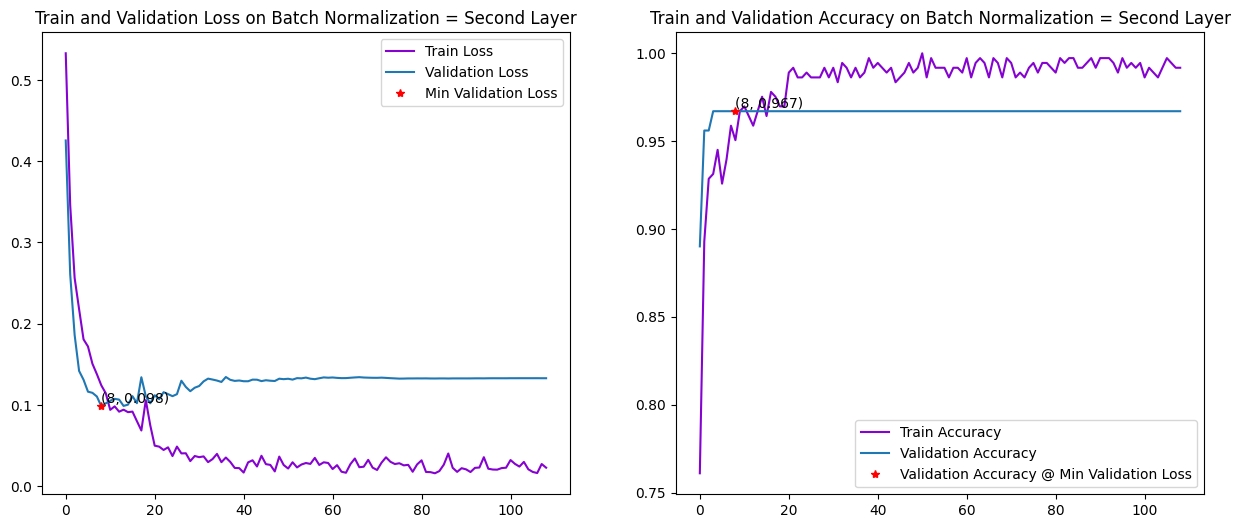

{'Train Accuracy': 0.9505494236946106,
 'Train Loss': 0.1240786537528038,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.09835225343704224,
 'Validation Recall': 0.9444444179534912}

In [119]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-BN--D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_batchnorm_df.loc[len(nn_batchnorm_df)] = new_row

model_history(history, f'Batch Normalization = Second Layer')
proc_data

In [120]:
nn_batchnorm_df

Model Name  Train Accuracy  Train Loss  Validation Accuracy  \
0  NN_30x30-BN-x5-D1-x1        0.967033    0.114210             0.967033   
1  NN_30x30x5-BN--D1-x1        0.950549    0.124079             0.967033   

   Validation Loss  Validation Recall  
0         0.102383           0.916667  
1         0.098352           0.944444

#### First Layer KFold

In [95]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.0542485199868679, Validation Accuracy STD: 0.028855358116868172
Validation Loss Mean: 0.0542485199868679, Validation Loss STD: 0.028855358116868172
Validation Recall Mean: 0.9762923240661621, Validation Recall STD: 0.01325861099787096


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.961538    0.133013             0.967033         0.079758   
1  1        0.972527    0.107942             0.989011         0.085234   
2  2        0.961538    0.094079             0.989011         0.035229   
3  3        0.991758    0.040949             1.000000         0.017404   
4  4        0.969780    0.101549             0.978022         0.053618   

   Validation Recall  
0           0.969697  
1           0.970588  
2           0.970588  
3           1.000000  
4           0.970588

#### Second Layer KFold

In [96]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Validation Accuracy Mean: {res_df['Validation Loss'].mean()}, Validation Accuracy STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Validation Accuracy Mean: 0.0714897695928812, Validation Accuracy STD: 0.03611158772140176
Validation Loss Mean: 0.0714897695928812, Validation Loss STD: 0.03611158772140176
Validation Recall Mean: 0.9764705777168274, Validation Recall STD: 0.024607649934571398


k  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  0        0.958791    0.132088             0.989011         0.056623   
1  1        0.983516    0.076530             0.978022         0.084476   
2  2        0.991758    0.028159             0.989011         0.022568   
3  3        0.953297    0.159446             0.967033         0.120794   
4  4        0.994505    0.028155             0.989011         0.072989   

   Validation Recall  
0           1.000000  
1           0.941176  
2           1.000000  
3           0.970588  
4           0.970588

Conclusion: This model didn't yield a higher validation score than our best model. <br>
For the rest of our parameters search, we will keep the previous best model.

In [97]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

## Dimensionality Reduction

### PCA

In [98]:
nn_pca_df = pd.DataFrame(columns=['PCA Components', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

In [99]:
from sklearn import decomposition
pca_5 = decomposition.PCA(n_components=5)
pca_10 = decomposition.PCA(n_components=10)
pca_15 = decomposition.PCA(n_components=15)
pca_20 = decomposition.PCA(n_components=20)

#### PCA N_Components=5

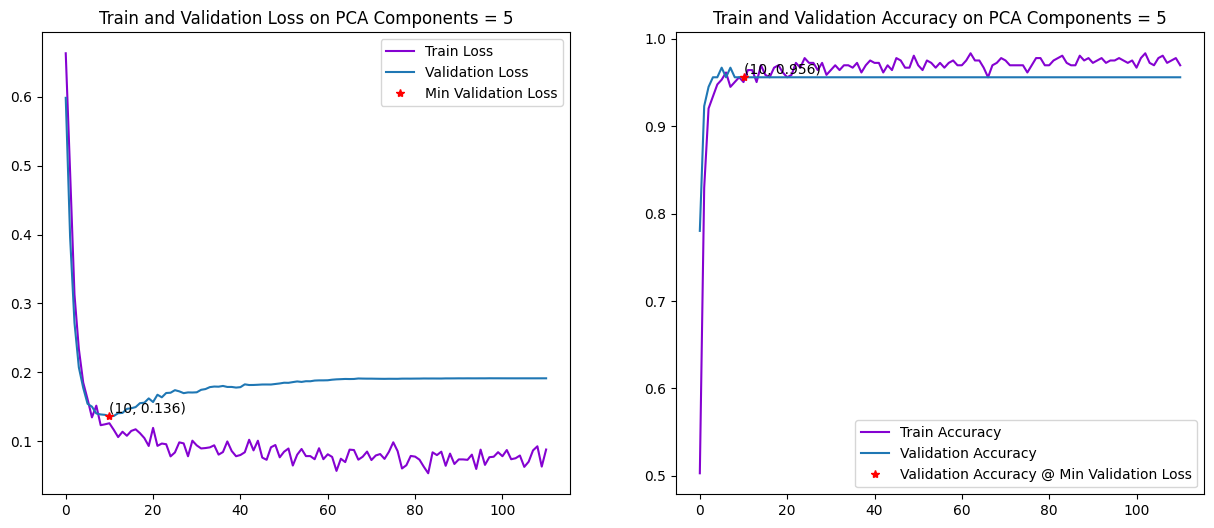

{'Train Accuracy': 0.9505494236946106,
 'Train Loss': 0.12590673565864563,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.13605041801929474,
 'Validation Recall': 0.9444444179534912}

In [100]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_5 = pca_5.fit_transform(XData_train)
X_test_pca_5 = pca_5.transform(XData_test)
X_val_pca_5 = pca_5.transform(XData_val)

model.add(layers.Input((X_train_pca_5.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_5 = RobustScaler()
X_train_pca_5 = scaler_pca_5.fit_transform(X_train_pca_5)
X_test_pca_5 = scaler_pca_5.transform(X_test_pca_5)
X_val_pca_5 = scaler_pca_5.transform(X_val_pca_5)

dataset = {'X_train': X_train_pca_5, 'y_train': y_train, 'X_val': X_val_pca_5, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 5, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 5')
proc_data

#### PCA N_Components=10

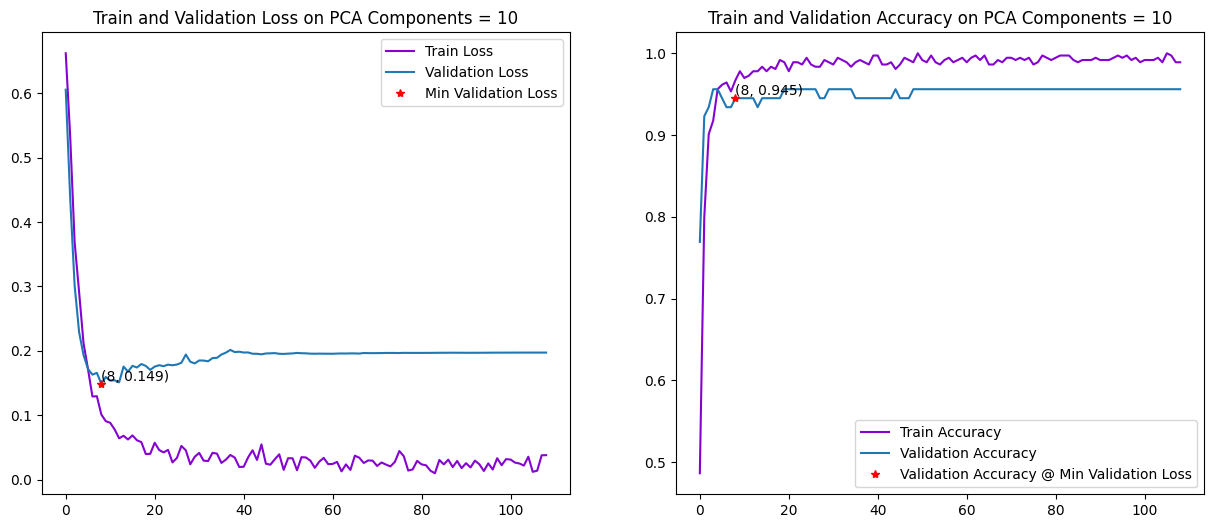

{'Train Accuracy': 0.9670329689979553,
 'Train Loss': 0.1009921059012413,
 'Validation Accuracy': 0.9450549483299255,
 'Validation Loss': 0.14872267842292786,
 'Validation Recall': 0.9166666865348816}

In [101]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_10 = pca_10.fit_transform(XData_train)
X_test_pca_10 = pca_10.transform(XData_test)
X_val_pca_10 = pca_10.transform(XData_val)

model.add(layers.Input((X_train_pca_10.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_10 = RobustScaler()
X_train_pca_10 = scaler_pca_10.fit_transform(X_train_pca_10)
X_test_pca_10 = scaler_pca_10.transform(X_test_pca_10)
X_val_pca_10 = scaler_pca_10.transform(X_val_pca_10)

dataset = {'X_train': X_train_pca_10, 'y_train': y_train, 'X_val': X_val_pca_10, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 10, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 10')
proc_data

#### PCA N_Components=15

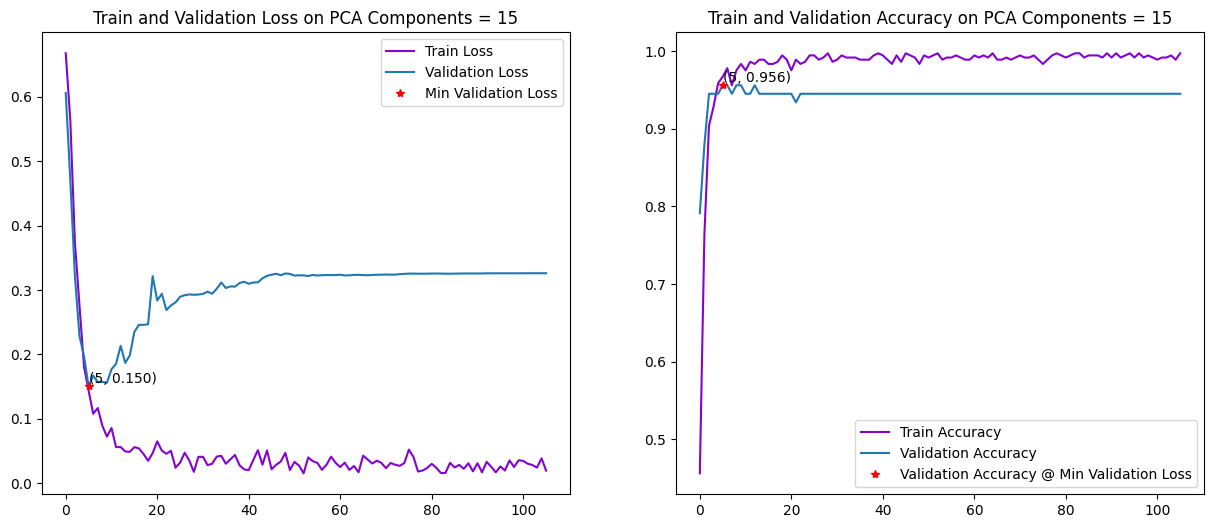

{'Train Accuracy': 0.9670329689979553,
 'Train Loss': 0.14385022222995758,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.15039438009262085,
 'Validation Recall': 0.9444444179534912}

In [102]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_15 = pca_15.fit_transform(XData_train)
X_test_pca_15 = pca_15.transform(XData_test)
X_val_pca_15 = pca_15.transform(XData_val)

model.add(layers.Input((X_train_pca_15.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_15 = RobustScaler()
X_train_pca_15 = scaler_pca_15.fit_transform(X_train_pca_15)
X_test_pca_15 = scaler_pca_15.transform(X_test_pca_15)
X_val_pca_15 = scaler_pca_15.transform(X_val_pca_15)

dataset = {'X_train': X_train_pca_15, 'y_train': y_train, 'X_val': X_val_pca_15, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 15, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 15')
proc_data

#### PCA N_Components=20

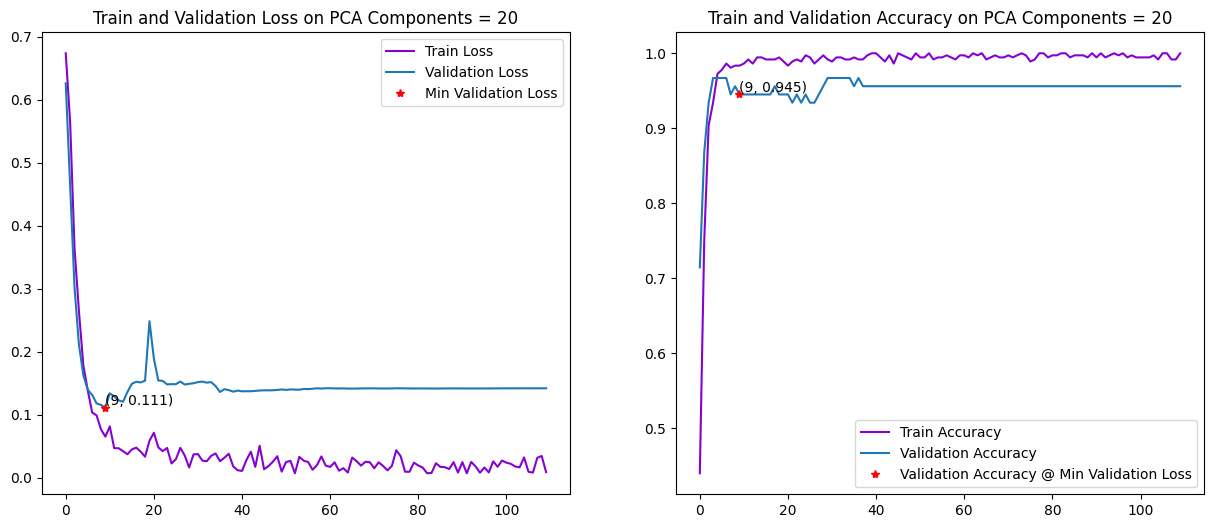

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.06529401987791061,
 'Validation Accuracy': 0.9450549483299255,
 'Validation Loss': 0.11148400604724884,
 'Validation Recall': 0.9444444179534912}

In [103]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_20 = pca_20.fit_transform(XData_train)
X_test_pca_20 = pca_20.transform(XData_test)
X_val_pca_20 = pca_20.transform(XData_val)

model.add(layers.Input((X_train_pca_20.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_20 = RobustScaler()
X_train_pca_20 = scaler_pca_20.fit_transform(X_train_pca_20)
X_test_pca_20 = scaler_pca_20.transform(X_test_pca_20)
X_val_pca_20 = scaler_pca_20.transform(X_val_pca_20)

dataset = {'X_train': X_train_pca_20, 'y_train': y_train, 'X_val': X_val_pca_20, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 20, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 20')
proc_data

In [104]:
nn_pca_df

PCA Components  Train Accuracy  Train Loss  Validation Accuracy  \
0               5        0.950549    0.125907             0.956044   
1              10        0.967033    0.100992             0.945055   
2              15        0.967033    0.143850             0.956044   
3              20        0.983516    0.065294             0.945055   

   Validation Loss  Validation Recall  
0         0.136050           0.944444  
1         0.148723           0.916667  
2         0.150394           0.944444  
3         0.111484           0.944444

Conclusion: In our case, using PCA didn't help our model to learn better. <br>
We do see that even with fewer features, the model can achieve good enough results.

### Features Correlation

In [105]:
nn_corr_df = pd.DataFrame(columns=['Threshold', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

As we saw in our EDA, there are some features that correlates to each other. Therefore, we can remove them in order to reduce the dimensionality of the problem and to make the model learn more easily. <br>
We will check how it affects the performance of our best model.

#### Correlation Matrix

Text(0.5, 1.05, 'Correlation of Breast Cancer Dataset Features')

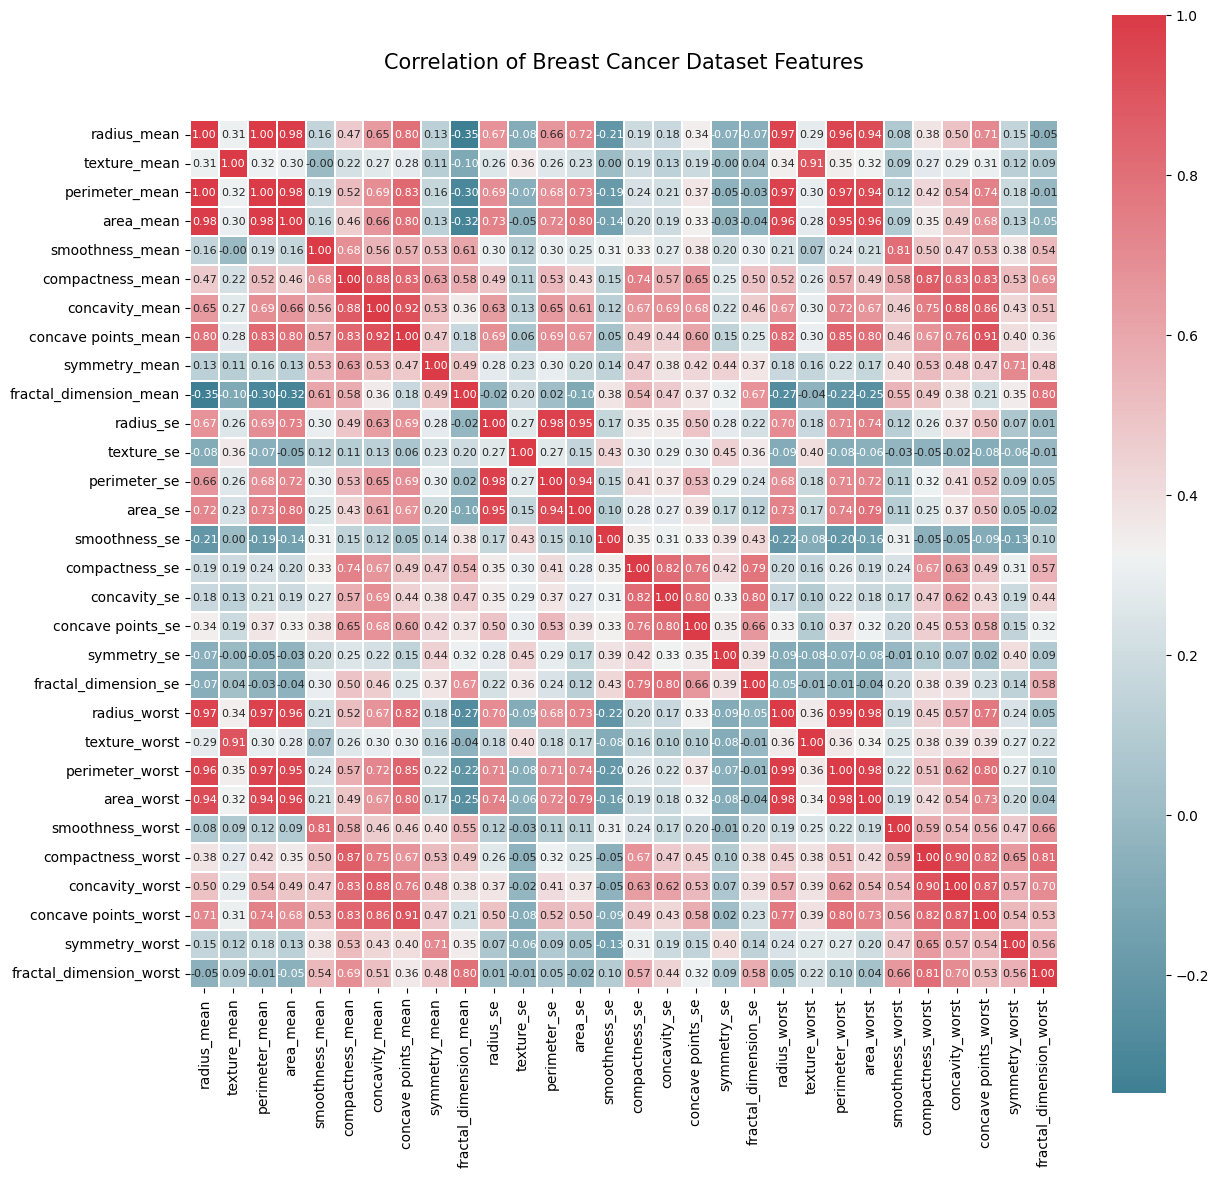

In [106]:
corr = XData_train.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Breast Cancer Dataset Features', y=1.05, size=15)

We can see there are some correlated features in our dataset. <br>
We will evaluate how many features we remove for different thresholds.

Remove features that are above the defined threshold

In [107]:
def get_corr_columns(X, threshold):

    # Compute the correlation matrix
    corr_matrix = X.corr()

    # Create a mask to identify upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of features with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]    
                                                                
    # Drop the highly correlated features
    X_reduced = X.drop(columns=to_drop)    

    return {'number of features to drop': len(to_drop), 'to_drop': to_drop, 'reduced': list(X_reduced.columns)}

df_corr_comp = pd.DataFrame(columns=['number of features to drop', 'to_drop', 'reduced'])
df_corr_comp.index.name = 'threshold'

thresholds = [0.85, 0.9, 0.95]

for threshold in thresholds:
    new_row = get_corr_columns(X, threshold)
    df_corr_comp.loc[threshold] = new_row

In [122]:
pd.set_option("max_colwidth", None)
pd.reset_option("max_colwidth")
df_corr_comp

number of features to drop  \
threshold                               
0.85                               13   
0.90                               10   
0.95                                7   

                                                     to_drop  \
threshold                                                      
0.85       [perimeter_mean, area_mean, concavity_mean, co...   
0.90       [perimeter_mean, area_mean, concave points_mea...   
0.95       [perimeter_mean, area_mean, perimeter_se, area...   

                                                     reduced  
threshold                                                     
0.85       [radius_mean, texture_mean, smoothness_mean, c...  
0.90       [radius_mean, texture_mean, smoothness_mean, c...  
0.95       [radius_mean, texture_mean, smoothness_mean, c...

We chose to check different high values of correlation in order to see how it influences the dimensons of the features. <br>
We assume that correlation value bigger than 0.9 means a high enough correlation for us to drop the feature. <br>

#### Correlation Threshold = 0.85

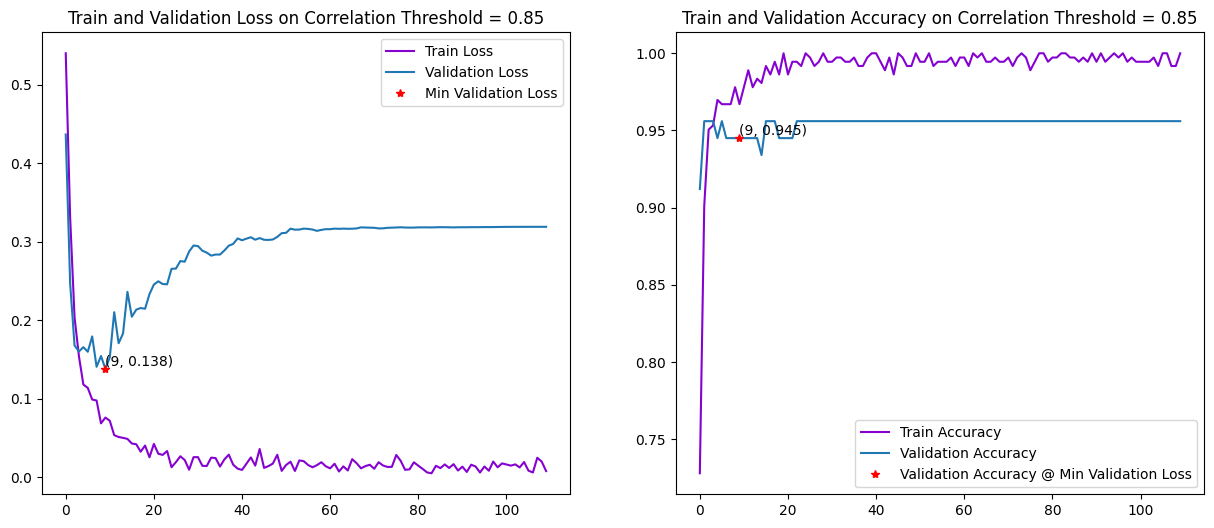

{'Train Accuracy': 0.9670329689979553,
 'Train Loss': 0.07615508884191513,
 'Validation Accuracy': 0.9450549483299255,
 'Validation Loss': 0.1381479799747467,
 'Validation Recall': 0.9444444179534912}

In [109]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

X_train_085 = XData_train.drop(columns=df_corr_comp.loc[0.85]['to_drop'])
X_test_085 = XData_test.drop(columns=df_corr_comp.loc[0.85]['to_drop'])
X_val_085 = XData_val.drop(columns=df_corr_comp.loc[0.85]['to_drop'])

model.add(layers.Input((X_train_085.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_085 = RobustScaler()
X_train_085 = scaler_085.fit_transform(X_train_085)
X_test_085 = scaler_085.transform(X_test_085)
X_val_085 = scaler_085.transform(X_val_085)

dataset = {'X_train': X_train_085, 'y_train': y_train, 'X_val': X_val_085, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'Threshold': 0.85, **proc_data}
nn_corr_df.loc[len(nn_corr_df)] = new_row

model_history(history, f'Correlation Threshold = 0.85')
proc_data

#### Correlation Threshold = 0.90

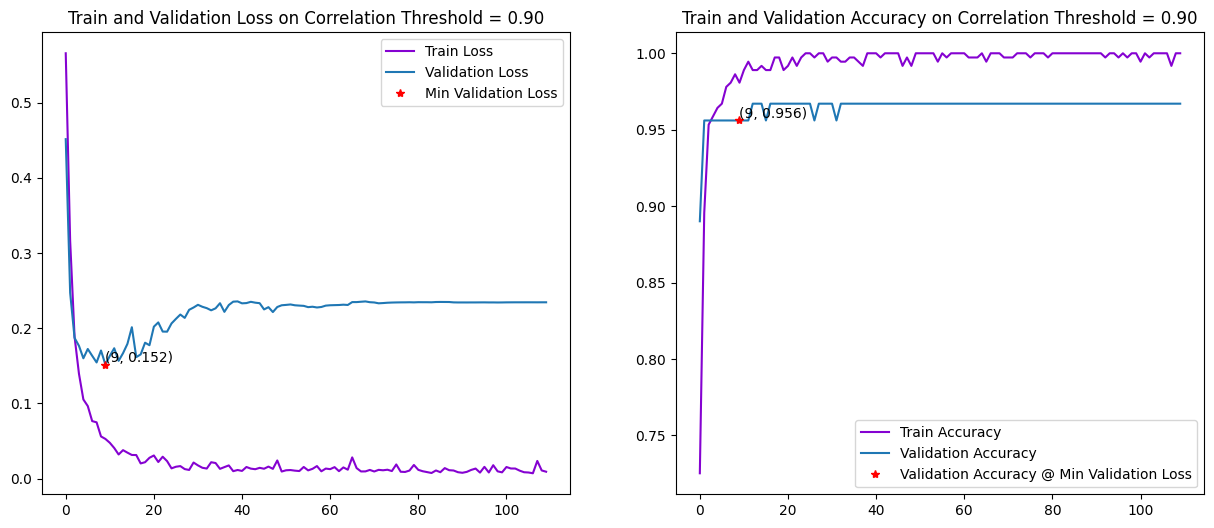

{'Train Accuracy': 0.9807692170143127,
 'Train Loss': 0.05281989276409149,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.15165843069553375,
 'Validation Recall': 0.9444444179534912}

In [110]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

X_train_090 = XData_train.drop(columns=df_corr_comp.loc[0.90]['to_drop'])
X_test_090 = XData_test.drop(columns=df_corr_comp.loc[0.90]['to_drop'])
X_val_090 = XData_val.drop(columns=df_corr_comp.loc[0.90]['to_drop'])

model.add(layers.Input((X_train_090.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_090 = RobustScaler()
X_train_090 = scaler_090.fit_transform(X_train_090)
X_test_090 = scaler_090.transform(X_test_090)
X_val_090 = scaler_090.transform(X_val_090)

dataset = {'X_train': X_train_090, 'y_train': y_train, 'X_val': X_val_090, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'Threshold': 0.90, **proc_data}
nn_corr_df.loc[len(nn_corr_df)] = new_row

model_history(history, f'Correlation Threshold = 0.90')
proc_data

#### Correlation Threshold = 0.95

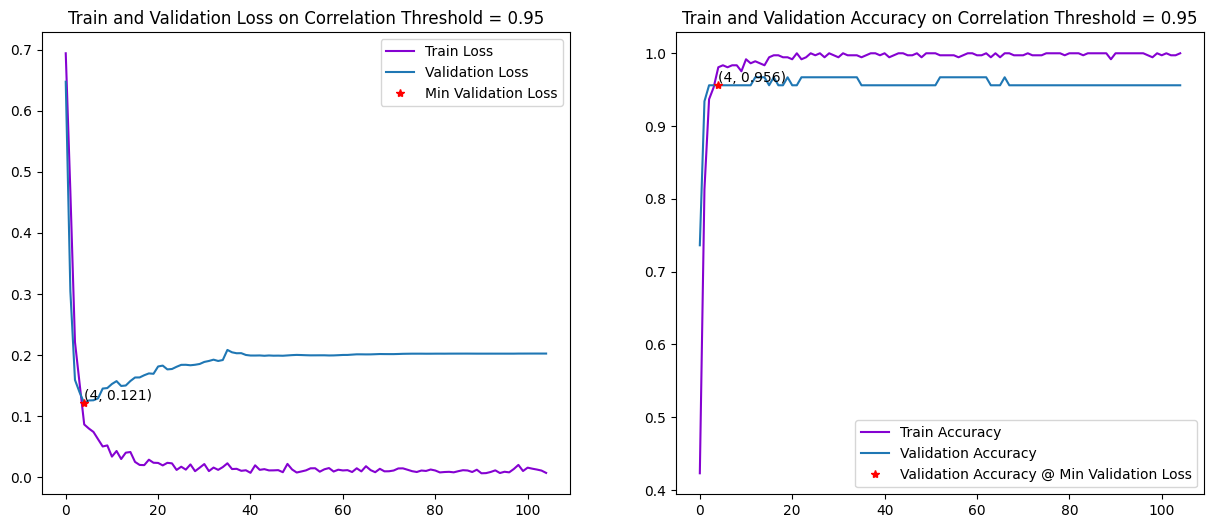

{'Train Accuracy': 0.9807692170143127,
 'Train Loss': 0.08639039844274521,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.12137550115585327,
 'Validation Recall': 0.9444444179534912}

In [111]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

X_train_095 = XData_train.drop(columns=df_corr_comp.loc[0.95]['to_drop'])
X_test_095 = XData_test.drop(columns=df_corr_comp.loc[0.95]['to_drop'])
X_val_095 = XData_val.drop(columns=df_corr_comp.loc[0.95]['to_drop'])

model.add(layers.Input((X_train_095.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_095 = RobustScaler()
X_train_095 = scaler_095.fit_transform(X_train_095)
X_test_095 = scaler_095.transform(X_test_095)
X_val_095 = scaler_095.transform(X_val_095)

dataset = {'X_train': X_train_095, 'y_train': y_train, 'X_val': X_val_095, 'y_val': y_val}
history, model = model_fit(model, epochNum=1000, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'Threshold': 0.95, **proc_data}
nn_corr_df.loc[len(nn_corr_df)] = new_row

model_history(history, f'Correlation Threshold = 0.95')
proc_data

In [112]:
nn_corr_df

Threshold  Train Accuracy  Train Loss  Validation Accuracy  \
0       0.85        0.967033    0.076155             0.945055   
1       0.90        0.980769    0.052820             0.956044   
2       0.95        0.980769    0.086390             0.956044   

   Validation Loss  Validation Recall  
0         0.138148           0.944444  
1         0.151658           0.944444  
2         0.121376           0.944444

Conclusion: In our case, dropping features that are correlated didn't help the model to learn better. <br>
We do see that even with fewer features, the model can achieve good enough results.